<h1><center>Sistemas Distribuídos – 2023/1

Prof. Rodolfo da Silva Villaça – rodolfo.villaca@ufes.br \\
Monitor: Eduardo M. Moraes Sarmento – eduardo.sarmento@ufes.br

Laboratório II – Aprendizado Federado usando a biblioteca Flower</h1></center>

<u>Objetivo</u>:\
Experimentar o treinamento de modelos de aprendizado de máquina por meio do *framework* de aprendizado *flwr*, disponível na biblioteca *flower* Comparar os resultados atingidos pelo modelo treinado de maneira local e federada.

Este roteiro de laboratório foi testado usando o [Google Colab](https://colab.research.google.com/), ambiente de desenvolvimento colaborativo Python disponibilizado pelo Google como um serviço em nuvem.\
\
Para a execução do código deste roteiro são necessárias as bibliotecas *tensorflow* (versão 2.12.0), *numpy* (versão 1.22.4), *ray* (versão 2.2.0), *matplotlib* (versão 3.7.1) e *flower* (versão 1.3.0). As quatro primeiras já vem instaladas no **Google Colab**,. ntão, caso esteja executando por ele, não é necessária sua instalação. A biblioteca flower não vem instalada,  então precisamos instalá-la, e também o seu módulo de simulação, para podermos simular o treinamento federado no *notebook*.

A célula seguinte executa a instalação de todas as bibliotecas necessárias. Caso esteja fora do Colab, é preciso descomentar as linhas de 3 a 5.

In [3]:
##!pip install flwr==1.3.0
##!pip install -U flwr["simulation"]
#!pip install ray==2.2.0
#!pip install tensorflow==2.12.0
#!pip install numpy==1.22.4
#!pip install matplotlib==3.7.1

###Célula de Importação 

Importamos a biblioteca *os*, que lida com o sistema operacional. Utilizamos ela para configurar a *flag* "TF_CPP_MIN_LOG_LEVEL" com o valor 3, isto faz com que os logs do *tensorflow* sejam menos verbosos durante o treinamento.\
Depois, importamos as demais bibliotecas: 

1.   *flower*, para efetuar o aprendizado federado;
2.   *tensorflow*, para definir uma arquitetura de rede neural, incluindo todas as camadas e otimizador que usaremos;
3.   *numpy*, biblioteca de maniupulação eficiente de vetores numéricos;
4.   *ray*, biblioteca utilizada pelo *flower* para instanciar a simulação do aprendizado federado.
5.   *matplotlib*, biblioteca para plotar gráficos.





In [101]:
import os
# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import flwr as fl
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D,Flatten,Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
import tensorflow_probability as tfp
import numpy as np
import ray
from matplotlib import pyplot as plt

#### Importação e Pré-rocessamento dos Dados

Neste laboratório usaremos o *dataset* MNIST, muito usado como referência na literatura. Este *dataset* é composto por imagens monocromáticas de 28 por 28 píxels (*28x28*), representando dígitos de 0 a 9 escritos a mão e anotadas com o valor do dígito. Ele contém dois *subdatasets*: o de treino e o de teste. O *subdataset* de treino é formado por 60 mil imagens, enquanto o *subdataset* de treino contém 10 mil imagens.

O *tensorflow* já nos provê esse *dataset*, separando os *subdatasets* de treino entre: atributos alvo, tambem chamados de classes ou *targets* (*y_train e y_test*), e atributos não alvo (*x_train* e *x_test*), ou *features*. Sendo assim, para carregar este *dataset* basta instanciar (atribuição da variavel *mnist*) e carregar (método *load_data*).

In [5]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 4s 0us/step


Plotamos, como exemplo, os 10 primeiros dígitos do *dataset* de treino com suas classes. Por meio desse *plot* conseguiremos visualizar bem o tipo de dado que o *dataset* descreve.

 Vemos que as classes são o valor numérico que o digito representa e as imagens são dígitos escritos a mão, em preto e branco.

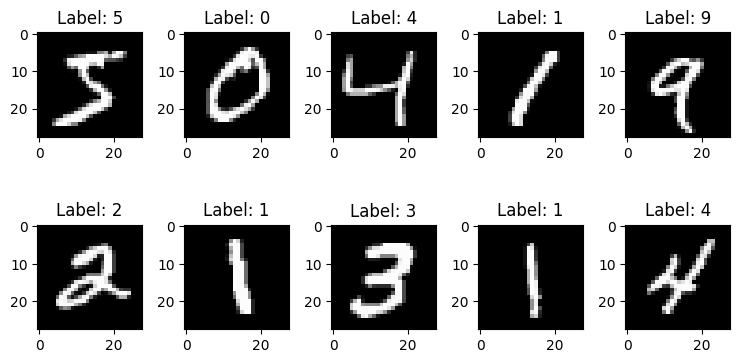

In [6]:
num = 10
images = x_train[:num]
labels = y_train[:num]
num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

**Pré-Processamento dos Dados**

 Primeiro trabalhamos com os dados dos atributos não alvo (*features*), checando o formato dos *datasets* nas variáveis *x_train e x_test*. emos que eles têm os formatos (60000, 28, 28) e (10000, 28, 28) respectivamente.

 O primeiro número indica a quantidade de imagens contidas em cada *dataset*: 60000 para o treino e 10000 para o teste. Os outros dois números são a quantidade de pixeis de cada imagem, 28 píxeis verticais e 28 píxeis horizontais.

Sendo assim, cada imagem é representada como matrizes de números (28 x 28). Já que as imagens são monocromáticas, cada elemento da matriz significa a luminosidade doassociad àquela posição do *pixel*,em valores que vão de 0 a 255.

In [7]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Para usar os *datasets* no treinamento e teste de modelos de aprendizado de máquina é necessario, inicialmente, pré-processar os dados.

Primeiro fazemos o *reshape*, incluindo uma nova dimensão que indica que as imagens são monocromaticas (*reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)*). 

Depois normalizamos os dados dos atributos não alvo, dividindo os valores de luminosidade dos pixeis pelo maior valor possivel, *255*, com isso fazendo com que estes valores fiquem na faixa entre 0 e 1. 

Com essas duas ações encerramos  pré-processamento dos atributos não alvo (*features*).

In [8]:
x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test=x_test/255.0

Para os atributos alvo (*target*) é necessário fazer o *one hot enconding* das classes. Esta operação consistem em transformar as classes adicionando novas colunas, que indicam a presença ou não da classe. Isto é, como neste *dataset* as classes são os números de 0 a 9, adicionamos 9 novas colunas, numeradas de 0 a 9. Para cada amostra, cada uma destas novas colunas terá os valores 0 ou 1, onde 0 indica   que a amostra não é daquela classe e 1 indica que a amostra é daquela classe. 

Printamos a primeira amostra do conjunto de treinamento , antes e depois da aplicação da operação, para vermos seu efeito sobre a amostra.

In [9]:
print(y_train[0])
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)
print(y_train[0])

5
tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


#### Treinamento Local

A técnica de aprendizado federado foi desenvolvida inicialmente para o treinamento de redes neurais, por isso precisamos definir uma rede neural para podermos usá-la localmente e,  futuramente, comparar os  resultados dos  modelos gerados localmente e federado.

Esta próxima célula define uma função que monta uma rede neural convolucional simples, que usaremos na etapa de treinamento. A rede neural recebe como atributos: o formato dos dados de entrada (*input_shape*) e o numero de classes do problema (*num_classes*).

In [10]:
def define_model(input_shape,num_classes):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
  model.add(MaxPool2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(num_classes, activation='softmax'))
  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

Conforme explicado anteriorment,  após o pré-processamento,  cada imagem do *dataset* terá o seguinte formato: 28 pixeis verticais, 28 pixeis horizontais e 1 canal de cor. Desta forma o formato de entrada dos dados é (28, 28, 1). 

Temos digitos de 0 a 9 em nosso *dataset*, ou seja, 10 possiveis classes. Com isso instanciamos uma rede neural usando a função *define_model* na variavel model.

In [11]:
input_shape = (28, 28, 1)
num_classes = 10

model = define_model(input_shape,num_classes)

Inicialmente treinaremos a rede neural localmente para termos um *baseline* de comparação. A rede neural  é treinada por 5 épocas, usando 10% do *dataset* de treino para validação durante o treinamento. 

Usamos 64 como *batch_size*, isso significa que  expomos a rede neural a 64 amostras (lote, ou *batch*) antes de atualizarmos o valor da função de perda. Esse processo  é repetido até que todas as amostras tenham sido expostas à rede neural, terminando uma época de treinamento. 

In [12]:
batch_size = 64
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1)

Epoch 1/5
844/844 [==============================] - 7s 8ms/step - loss: 0.2224 - accuracy: 0.9318 - val_loss: 0.0850 - val_accuracy: 0.9768
Epoch 2/5
844/844 [==============================] - 7s 8ms/step - loss: 0.0798 - accuracy: 0.9766 - val_loss: 0.0668 - val_accuracy: 0.9807
Epoch 3/5
844/844 [==============================] - 7s 8ms/step - loss: 0.0523 - accuracy: 0.9846 - val_loss: 0.0489 - val_accuracy: 0.9868
Epoch 4/5
844/844 [==============================] - 7s 8ms/step - loss: 0.0393 - accuracy: 0.9878 - val_loss: 0.0481 - val_accuracy: 0.9865
Epoch 5/5
844/844 [==============================] - 7s 8ms/step - loss: 0.0307 - accuracy: 0.9908 - val_loss: 0.0463 - val_accuracy: 0.9873


Como conclusão, com o conjunto de teste usado neste laboratório, e usando  o nosso modelo,  obtivemos uma acurácia de ~98,39%, que é um resultado aceitável com relação a este *dataset*, comparando-se com os resultados de referência encontrados na literatura. Ver [referência](https://paperswithcode.com/sota/image-classification-on-mnist).

In [13]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - accuracy: 0.9861


#### Treinamento Federado

Agora começaremos o treinamento federado desta mesma rede neural usando a biblioteca *flower*. Esta biblioteca implementa a arquitetura de aprendizado federado, onde no treinamento temos dois agentes: o servidor e os clientes. 
 
* Os clientes (treinadores) têm como tarefa treinar seus modelos usando seus dados locais e, após o treinamento, enviar os pesos encontrados para o servidor de agregação. Quando receberem os pesos agregados pelo servidor, os clientes atualizam seus modelos locais com estes pesos e recomeçam o treinamento, assim iniciando uma nova rodada (época).
* O servidor de agregação, por sua vez, recebe estes pesos e usa algum algoritmo para agregar os diferentes pesos dos modelos gerados pelos clientes treinadores. Em seguida o servidor deve enviar de volta os pesos agregados para os clientes. 

Ao final desse processo,  os  pesos agregados representam o modelo global que está sendo treinado por esse conjunto de treinadores.







Sabendo disso, para o uso da biblioteca *flower* temos, como primeiro passo, que implementar o código dos clientes. Para isso definimos uma classe cliente que herda da super classe *NumPyClient* provida pela biblioteca *numpy*. Para seu uso temos que implementar obrigatoriamente 3 métodos em nosso cliente:


1.  *get_parameters(self, config)*: este método recebe um dicionário de configuração e é chamado pelo servidor como um procedimento remoto. Ele retorna os pesos do modelo do cliente na rodada atual.
2.  *fit(self, parameters, config)*: por este método, chamado via RPC pelo servidor, o cliente recebe os pesos do modelo global e um dicionário de configuração. Ele realiza o treinamento do modelo, primeiro setando os pesos do modelo com os recebidos pelo cliente do servidor e depois treinando um novo modelo com esses novos pesos iniciais. Ela retorna: os pesos encontrados após essa rodada de treinamento, o tamanho do conjunto de treinamento e um dicionário de métricas de avaliação do modelo. O dicionário pode ser retornado vazio.
3.  *evaluate(self, parameters, config)*: por este método, chamado remotamente pelo servidor, o cliente recebe os pesos do modelo global e um dicionário de configuração. Ele avalia localmente o modelo treinado e retorna o valor da função de perda encontrado para este cliente, o tamanho do conjunto de teste e um dicionário de métricas de avaliação do modelo. Neste caso, retornaremos a acurácia.

Também definimos um método opcional *\_\_init\_\_(self, model, x_train, y_train, x_test, y_test)* que é o de inicialização do objeto, recebendo o modelo pré-instanciado e os conjuntos de teste e treino.



In [14]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_test, y_test) -> None:
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=1, verbose=2)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(self.x_test, self.y_test, verbose=2)
        return loss, len(self.x_test), {"accuracy": acc}

Como estamos usando um *notebook*, não podemos instanciar clientes e servidores do *flower* diretamente. Por isso a biblioteca prove uma alternativa que é o módulo de simulação. Ele simula o aprendizado federado sem o uso de conexões de rede.\
\
Para o seu uso temos que definir uma função que instancias os clientes com a assinatura *fn(str) -> fl.client.Client*. Esta função recebe uma *string* que é um identificador único do cliente usado pela simulação e nos retorna o cliente instanciado. Internamente ela particiona o *dataset*, amostrando, sem reposição, um número aleatório de imagens, compondo um conjunto de dados que representa os dados locais daquele cliente. 

A seguir faremos os mesmos passos anteriores de pré-processamento e instanciamento da rede neural. Finalmente instanciaremos um cliente *flower* e retornamos.

In [15]:
def client_fn_random(cid: str) -> fl.client.Client:
    input_shape = (28, 28, 1)
    num_classes = 10
    num_clients = 10
    partition_size = 500
    

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    #sample_size_train = int(cid) * partition_size
    #sample_size_test = int(cid) * partition_size
    sample_size_train = int((1/num_clients)*len(x_train))
    sample_size_test = int((1/num_clients)*len(x_test))
    idx_train = np.random.choice(np.arange(len(x_train)), sample_size_train, replace=False)
    x_train = x_train[idx_train]/255.0
    y_train = y_train[idx_train]
    y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
    idx_test = np.random.choice(np.arange(len(x_test)), sample_size_test, replace=False)
    x_test = x_test[idx_test]/255.0
    y_test = y_test[idx_test]
    y_test = tf.one_hot(y_test.astype(np.int32), depth=10)
    model = define_model(input_shape,num_classes)
    # Create and return client
    return FlowerClient(model, x_train, y_train, x_test, y_test)

Para a avaliação do modelo precisamos de uma função de agregação de métricas. Isto é necessário pois, a priori, a simulação não sabe que tipo de métrica será usada para avaliar o modelo. Por isso o programador tem que criar uma função que lide com a agregação dos valores de métricas que ele esta usando para avaliar seu modelo. Desta maneira esta função é usada para que a simulação consiga retornar a evolução dos valores das métricas em cada *round* usando um objeto do tipo *history*.


Aqui definimos a função de agregação como a média ponderada da acurácia pelo tamanho do conjunto de dados de cada cliente.

In [16]:
def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    acc = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    results = {"accuracy": sum(acc) / sum(examples)}
    return results

Precisamos agora definir o número de clientes que participação do aprendizado federado, 10 clientes neste exemplo, e uma estratégia de agregação dos pesos a ser usada pelo servidor.

Esta estratégia é um objeto do tipo *strategy* da biblioteca *flower*. Além de definir o algoritmo de agregação dos pesos, no caso usamos o *Federated Average (FedAvg)*, também é preciso configurar o comportamento do servidor durante o processo de treinamento. Com essa biblioteca nós configuramos o servidor para:

1.   Escolher aleatoriamente 90% dos clientes (9 clientes neste exemplo) para o treinamento (*fraction_fit*);
2.   Usar todos os clientes para a avaliação do modelo (*fraction_evaluate*);
3.   Nunca usar menos que 9 clientes para o treinamento (*min_fit_clients*);
4.   Nunca usar menos que 9 clientes para a avaliação do modelo (*min_evaluate_clients*);
5.   Esperar que tenha pelo menos 9 clientes prontos antes de começar o treinamento(*min_available_clients*);
6.   Usar a função *weighted_average*, definida anteriormente, como função de agregação de métricas

Finalmente iniciamos a simulação usando a função *fl.simulation.start_simulation*. Passamos para essa função a função de instanciamento de clientes (*client_fn_random*), o número de clientes (*num_clients*), um dicionário de configuração, que diz para o servidor quantos *rounds* de treinamento queremos (*fl.server.ServerConfig(num_rounds=5)*) e a estratégia de treinamento (*strategy*). 


In [17]:
num_clients = 10

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.9,  
    fraction_evaluate=1,  
    min_fit_clients=9,  
    min_evaluate_clients=9,  
    min_available_clients=int(
        num_clients * 0.9
    ),  
    evaluate_metrics_aggregation_fn=weighted_average,
)

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn_random,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    
)

INFO flwr 2023-04-17 19:32:46,152 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-17 19:32:47,398	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-17 19:32:48,282 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:192.168.15.122': 1.0, 'accelerator_type:G': 1.0, 'memory': 4792221696.0, 'GPU': 1.0, 'CPU': 8.0, 'object_store_memory': 2396110848.0}
INFO flwr 2023-04-17 19:32:48,283 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-17 19:32:48,283 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-04-17 19:32:51,286 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-04-17 19:32:51,287 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-17 19:32:51,287 | server.py:101 | FL starting
DEBUG flwr 2023-04-17 19:32:51,288 | server.py:215 | fit_round 1: strategy sa

(launch_and_fit pid=138941) 188/188 - 4s - loss: 0.5190 - accuracy: 0.8347 - 4s/epoch - 24ms/step
(launch_and_fit pid=138938) 188/188 - 6s - loss: 0.5222 - accuracy: 0.8362 - 6s/epoch - 33ms/step
(launch_and_fit pid=138936) 188/188 - 6s - loss: 0.5373 - accuracy: 0.8300 - 6s/epoch - 34ms/step
(launch_and_fit pid=138937) 188/188 - 6s - loss: 0.5370 - accuracy: 0.8295 - 6s/epoch - 34ms/step
(launch_and_fit pid=138939) 188/188 - 7s - loss: 0.5119 - accuracy: 0.8370 - 7s/epoch - 35ms/step
(launch_and_fit pid=138940) 188/188 - 7s - loss: 0.5019 - accuracy: 0.8405 - 7s/epoch - 35ms/step
(launch_and_fit pid=138942) 188/188 - 7s - loss: 0.5301 - accuracy: 0.8355 - 7s/epoch - 35ms/step
(launch_and_fit pid=138935) 188/188 - 7s - loss: 0.4963 - accuracy: 0.8452 - 7s/epoch - 35ms/step


DEBUG flwr 2023-04-17 19:33:02,113 | server.py:229 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-04-17 19:33:02,155 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-17 19:33:02,155 | server.py:165 | evaluate_round 1: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=138941) 188/188 - 5s - loss: 0.5330 - accuracy: 0.8315 - 5s/epoch - 25ms/step
(launch_and_evaluate pid=138941) 32/32 - 1s - loss: 0.2258 - accuracy: 0.9380 - 561ms/epoch - 18ms/step
(launch_and_evaluate pid=138938) 32/32 - 1s - loss: 0.2602 - accuracy: 0.9200 - 549ms/epoch - 17ms/step
(launch_and_evaluate pid=138939) 32/32 - 1s - loss: 0.2327 - accuracy: 0.9330 - 565ms/epoch - 18ms/step
(launch_and_evaluate pid=138936) 32/32 - 1s - loss: 0.2496 - accuracy: 0.9310 - 535ms/epoch - 17ms/step
(launch_and_evaluate pid=138935) 32/32 - 1s - loss: 0.2799 - accuracy: 0.9190 - 538ms/epoch - 17ms/step
(launch_and_evaluate pid=138937) 32/32 - 1s - loss: 0.2352 - accuracy: 0.9430 - 571ms/epoch - 18ms/step
(launch_and_evaluate pid=138940) 32/32 - 1s - loss: 0.2763 - accuracy: 0.9220 - 548ms/epoch - 17ms/step
(launch_and_evaluate pid=138942) 32/32 - 1s - loss: 0.1953 - accuracy: 0.9470 - 545ms/epoch - 17ms/step


DEBUG flwr 2023-04-17 19:33:03,840 | server.py:179 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:33:03,841 | server.py:215 | fit_round 2: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=138936) 32/32 - 0s - loss: 0.2124 - accuracy: 0.9410 - 218ms/epoch - 7ms/step
(launch_and_evaluate pid=138935) 32/32 - 0s - loss: 0.2326 - accuracy: 0.9310 - 219ms/epoch - 7ms/step
(launch_and_fit pid=138935) 188/188 - 6s - loss: 0.2379 - accuracy: 0.9300 - 6s/epoch - 33ms/step
(launch_and_fit pid=138936) 188/188 - 6s - loss: 0.2525 - accuracy: 0.9198 - 6s/epoch - 34ms/step
(launch_and_fit pid=138941) 188/188 - 7s - loss: 0.2479 - accuracy: 0.9247 - 7s/epoch - 35ms/step
(launch_and_fit pid=138937) 188/188 - 7s - loss: 0.2539 - accuracy: 0.9245 - 7s/epoch - 35ms/step
(launch_and_fit pid=138939) 188/188 - 7s - loss: 0.2564 - accuracy: 0.9233 - 7s/epoch - 36ms/step
(launch_and_fit pid=138938) 188/188 - 7s - loss: 0.2478 - accuracy: 0.9245 - 7s/epoch - 36ms/step
(launch_and_fit pid=138940) 188/188 - 7s - loss: 0.2700 - accuracy: 0.9193 - 7s/epoch - 36ms/step
(launch_and_fit pid=138942) 188/188 - 7s - loss: 0.2590 - accuracy: 0.9265 - 7s/epoch - 36ms/step


DEBUG flwr 2023-04-17 19:33:12,757 | server.py:229 | fit_round 2 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:33:12,774 | server.py:165 | evaluate_round 2: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=138935) 188/188 - 1s - loss: 0.2537 - accuracy: 0.9255 - 1s/epoch - 7ms/step
(launch_and_evaluate pid=138941) 32/32 - 1s - loss: 0.1470 - accuracy: 0.9580 - 545ms/epoch - 17ms/step
(launch_and_evaluate pid=138938) 32/32 - 1s - loss: 0.1488 - accuracy: 0.9590 - 606ms/epoch - 19ms/step
(launch_and_evaluate pid=138939) 32/32 - 1s - loss: 0.1450 - accuracy: 0.9590 - 576ms/epoch - 18ms/step
(launch_and_evaluate pid=138935) 32/32 - 1s - loss: 0.1475 - accuracy: 0.9590 - 624ms/epoch - 20ms/step
(launch_and_evaluate pid=138937) 32/32 - 1s - loss: 0.1513 - accuracy: 0.9530 - 563ms/epoch - 18ms/step
(launch_and_evaluate pid=138940) 32/32 - 1s - loss: 0.1482 - accuracy: 0.9580 - 586ms/epoch - 18ms/step
(launch_and_evaluate pid=138942) 32/32 - 1s - loss: 0.1641 - accuracy: 0.9480 - 565ms/epoch - 18ms/step
(launch_and_evaluate pid=138936) 32/32 - 0s - loss: 0.1766 - accuracy: 0.9500 - 448ms/epoch - 14ms/step


DEBUG flwr 2023-04-17 19:33:14,639 | server.py:179 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:33:14,640 | server.py:215 | fit_round 3: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=138941) 32/32 - 0s - loss: 0.1424 - accuracy: 0.9650 - 270ms/epoch - 8ms/step
(launch_and_evaluate pid=138939) 32/32 - 0s - loss: 0.1556 - accuracy: 0.9510 - 278ms/epoch - 9ms/step
(launch_and_fit pid=138936) 188/188 - 7s - loss: 0.1855 - accuracy: 0.9448 - 7s/epoch - 37ms/step
(launch_and_fit pid=138938) 188/188 - 7s - loss: 0.1623 - accuracy: 0.9533 - 7s/epoch - 39ms/step
(launch_and_fit pid=138940) 188/188 - 7s - loss: 0.1804 - accuracy: 0.9465 - 7s/epoch - 39ms/step
(launch_and_fit pid=138937) 188/188 - 7s - loss: 0.1846 - accuracy: 0.9422 - 7s/epoch - 40ms/step
(launch_and_fit pid=138939) 188/188 - 8s - loss: 0.1837 - accuracy: 0.9457 - 8s/epoch - 40ms/step
(launch_and_fit pid=138935) 188/188 - 8s - loss: 0.1780 - accuracy: 0.9452 - 8s/epoch - 40ms/step
(launch_and_fit pid=138942) 188/188 - 8s - loss: 0.1865 - accuracy: 0.9423 - 8s/epoch - 41ms/step
(launch_and_fit pid=138941) 188/188 - 8s - loss: 0.1928 - accuracy: 0.9445 - 8s/epoch - 41ms/step


DEBUG flwr 2023-04-17 19:33:24,225 | server.py:229 | fit_round 3 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:33:24,246 | server.py:165 | evaluate_round 3: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=138936) 188/188 - 1s - loss: 0.1687 - accuracy: 0.9513 - 1s/epoch - 7ms/step
(launch_and_evaluate pid=138941) 32/32 - 1s - loss: 0.1132 - accuracy: 0.9670 - 525ms/epoch - 16ms/step
(launch_and_evaluate pid=138938) 32/32 - 1s - loss: 0.1396 - accuracy: 0.9610 - 535ms/epoch - 17ms/step
(launch_and_evaluate pid=138939) 32/32 - 1s - loss: 0.1270 - accuracy: 0.9630 - 534ms/epoch - 17ms/step
(launch_and_evaluate pid=138936) 32/32 - 1s - loss: 0.1360 - accuracy: 0.9610 - 536ms/epoch - 17ms/step
(launch_and_evaluate pid=138935) 32/32 - 1s - loss: 0.1097 - accuracy: 0.9690 - 529ms/epoch - 17ms/step
(launch_and_evaluate pid=138937) 32/32 - 1s - loss: 0.1253 - accuracy: 0.9610 - 531ms/epoch - 17ms/step
(launch_and_evaluate pid=138940) 32/32 - 1s - loss: 0.1264 - accuracy: 0.9630 - 535ms/epoch - 17ms/step
(launch_and_evaluate pid=138942) 32/32 - 1s - loss: 0.1370 - accuracy: 0.9590 - 521ms/epoch - 16ms/step


DEBUG flwr 2023-04-17 19:33:25,856 | server.py:179 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:33:25,856 | server.py:215 | fit_round 4: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=138941) 32/32 - 0s - loss: 0.0960 - accuracy: 0.9700 - 227ms/epoch - 7ms/step
(launch_and_evaluate pid=138935) 32/32 - 0s - loss: 0.0953 - accuracy: 0.9750 - 228ms/epoch - 7ms/step
(launch_and_fit pid=138939) 188/188 - 7s - loss: 0.1440 - accuracy: 0.9578 - 7s/epoch - 36ms/step
(launch_and_fit pid=138940) 188/188 - 7s - loss: 0.1400 - accuracy: 0.9588 - 7s/epoch - 40ms/step
(launch_and_fit pid=138937) 188/188 - 8s - loss: 0.1387 - accuracy: 0.9570 - 8s/epoch - 40ms/step
(launch_and_fit pid=138938) 188/188 - 8s - loss: 0.1465 - accuracy: 0.9560 - 8s/epoch - 41ms/step
(launch_and_fit pid=138941) 188/188 - 8s - loss: 0.1376 - accuracy: 0.9580 - 8s/epoch - 42ms/step
(launch_and_fit pid=138935) 188/188 - 8s - loss: 0.1376 - accuracy: 0.9590 - 8s/epoch - 42ms/step
(launch_and_fit pid=138942) 188/188 - 8s - loss: 0.1492 - accuracy: 0.9515 - 8s/epoch - 41ms/step
(launch_and_fit pid=138936) 188/188 - 8s - loss: 0.1455 - accuracy: 0.9558 - 8s/epoch - 42ms/step


DEBUG flwr 2023-04-17 19:33:35,697 | server.py:229 | fit_round 4 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:33:35,714 | server.py:165 | evaluate_round 4: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=138939) 188/188 - 1s - loss: 0.1378 - accuracy: 0.9600 - 1s/epoch - 7ms/step
(launch_and_evaluate pid=138936) 32/32 - 1s - loss: 0.0924 - accuracy: 0.9760 - 543ms/epoch - 17ms/step
(launch_and_evaluate pid=138941) 32/32 - 1s - loss: 0.0822 - accuracy: 0.9760 - 558ms/epoch - 17ms/step
(launch_and_evaluate pid=138938) 32/32 - 1s - loss: 0.0884 - accuracy: 0.9740 - 567ms/epoch - 18ms/step
(launch_and_evaluate pid=138939) 32/32 - 1s - loss: 0.0662 - accuracy: 0.9820 - 555ms/epoch - 17ms/step
(launch_and_evaluate pid=138935) 32/32 - 1s - loss: 0.0915 - accuracy: 0.9770 - 564ms/epoch - 18ms/step
(launch_and_evaluate pid=138937) 32/32 - 1s - loss: 0.1005 - accuracy: 0.9660 - 554ms/epoch - 17ms/step
(launch_and_evaluate pid=138940) 32/32 - 1s - loss: 0.0930 - accuracy: 0.9720 - 578ms/epoch - 18ms/step
(launch_and_evaluate pid=138942) 32/32 - 1s - loss: 0.0673 - accuracy: 0.9800 - 541ms/epoch - 17ms/step


DEBUG flwr 2023-04-17 19:33:37,395 | server.py:179 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:33:37,395 | server.py:215 | fit_round 5: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=138939) 32/32 - 0s - loss: 0.0886 - accuracy: 0.9780 - 221ms/epoch - 7ms/step
(launch_and_evaluate pid=138936) 32/32 - 0s - loss: 0.0681 - accuracy: 0.9850 - 223ms/epoch - 7ms/step
(launch_and_fit pid=138941) 188/188 - 8s - loss: 0.1195 - accuracy: 0.9665 - 8s/epoch - 43ms/step
(launch_and_fit pid=138939) 188/188 - 8s - loss: 0.1241 - accuracy: 0.9652 - 8s/epoch - 44ms/step
(launch_and_fit pid=138936) 188/188 - 8s - loss: 0.1174 - accuracy: 0.9660 - 8s/epoch - 43ms/step
(launch_and_fit pid=138938) 188/188 - 8s - loss: 0.1238 - accuracy: 0.9637 - 8s/epoch - 44ms/step
(launch_and_fit pid=138935) 188/188 - 8s - loss: 0.1128 - accuracy: 0.9652 - 8s/epoch - 44ms/step
(launch_and_fit pid=138937) 188/188 - 8s - loss: 0.1054 - accuracy: 0.9698 - 8s/epoch - 44ms/step
(launch_and_fit pid=138942) 188/188 - 8s - loss: 0.1121 - accuracy: 0.9663 - 8s/epoch - 44ms/step
(launch_and_fit pid=138940) 188/188 - 9s - loss: 0.1082 - accuracy: 0.9683 - 9s/epoch - 45ms/step


DEBUG flwr 2023-04-17 19:33:48,271 | server.py:229 | fit_round 5 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:33:48,290 | server.py:165 | evaluate_round 5: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=138936) 188/188 - 2s - loss: 0.1119 - accuracy: 0.9655 - 2s/epoch - 8ms/step
(launch_and_evaluate pid=138936) 32/32 - 1s - loss: 0.0877 - accuracy: 0.9710 - 536ms/epoch - 17ms/step
(launch_and_evaluate pid=138939) 32/32 - 1s - loss: 0.0725 - accuracy: 0.9800 - 613ms/epoch - 19ms/step
(launch_and_evaluate pid=138935) 32/32 - 1s - loss: 0.0830 - accuracy: 0.9780 - 627ms/epoch - 20ms/step
(launch_and_evaluate pid=138937) 32/32 - 1s - loss: 0.0876 - accuracy: 0.9760 - 633ms/epoch - 20ms/step
(launch_and_evaluate pid=138940) 32/32 - 1s - loss: 0.0873 - accuracy: 0.9700 - 580ms/epoch - 18ms/step
(launch_and_evaluate pid=138941) 32/32 - 1s - loss: 0.0785 - accuracy: 0.9770 - 699ms/epoch - 22ms/step
(launch_and_evaluate pid=138938) 32/32 - 1s - loss: 0.0787 - accuracy: 0.9780 - 678ms/epoch - 21ms/step
(launch_and_evaluate pid=138942) 32/32 - 1s - loss: 0.0620 - accuracy: 0.9830 - 631ms/epoch - 20ms/step


DEBUG flwr 2023-04-17 19:33:50,185 | server.py:179 | evaluate_round 5 received 10 results and 0 failures
INFO flwr 2023-04-17 19:33:50,185 | server.py:144 | FL finished in 58.89755496196449
INFO flwr 2023-04-17 19:33:50,187 | app.py:202 | app_fit: losses_distributed [(1, 0.240008844435215), (2, 0.15264221429824829), (3, 0.12054684460163116), (4, 0.0838056318461895), (5, 0.08106904253363609)]
INFO flwr 2023-04-17 19:33:50,188 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.932500010728836), (2, 0.9559999942779541), (3, 0.9649000108242035), (4, 0.9766000032424926), (5, 0.9762000024318696)]}
INFO flwr 2023-04-17 19:33:50,189 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-04-17 19:33:50,189 | app.py:205 | app_fit: metrics_centralized {}


(launch_and_evaluate pid=138936) 32/32 - 0s - loss: 0.0945 - accuracy: 0.9710 - 271ms/epoch - 8ms/step


Printamos os resultados do treinamento retornados no formato do objeto *history*. Ele tem dois atributos: um dicionário com a média da função de perda a cada *round* e um dicionário com os valores das métricas agregadas a cada *round*, calculadas pela função de agregação. 

Podemos observar a evolução destes dois valores a cada *round*. Para os 4 primeiros *rounds* tivemos uma melhora do valor da função de perda e da acurácia, mas no último *round* a função de perda diminuiu pouco e a acurácia se manteve estável.

O número de *rounds* de treinamento é um valor muito importante para o aprendizado federado. Similar ao número de épocas de treinamento no aprendizado local, precisamos de *rounds* suficientes para que o modelo convirja com pesos adequados, mas temos que tomar cuidado para não causar o *overfitting* da rede, caso tenhamos muitos *rounds*.

In [18]:
print(history)

History (loss, distributed):
	round 1: 0.240008844435215
	round 2: 0.15264221429824829
	round 3: 0.12054684460163116
	round 4: 0.0838056318461895
	round 5: 0.08106904253363609
History (metrics, distributed):
{'accuracy': [(1, 0.932500010728836), (2, 0.9559999942779541), (3, 0.9649000108242035), (4, 0.9766000032424926), (5, 0.9762000024318696)]}


A seguir plotaremos a acurácia por *round*. Observe que ela parece estar tendendo a aumentar a cada *round* e, **talvez**, se aumentássemos o numero de *rounds* teríamos uma acurácia ainda melhor.

(launch_and_evaluate pid=138940) 32/32 - 0s - loss: 0.0789 - accuracy: 0.9780 - 299ms/epoch - 9ms/step


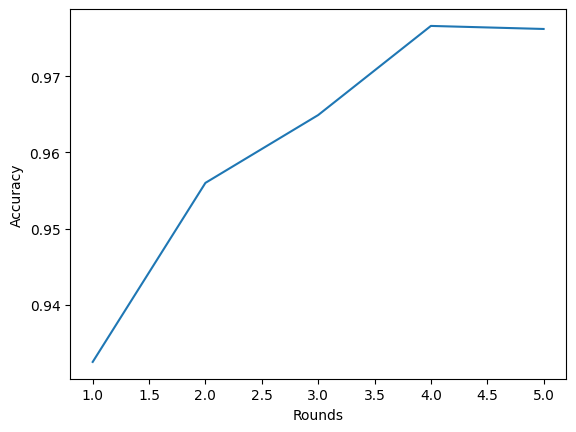

In [19]:
plt.plot(*zip(*history.metrics_distributed['accuracy']))
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.show()

#### Atividades

**Atividade 1** 

Durante a configuração do treinamento federado definimos valores para muitos hyper-parâmetros. Um dos mais importantes é foi o número de *rounds*. Por isso nesta tarefa vocês deverão treinar a rede de maneira federada variando o número de rounds em diferentes valores. 

 

*   Os valores a serem usados para o número de *rounds* são 10, 15, 20;
*   Para cada valor deve-se plotar um gráfico de linha que relaciona o número de *rounds* com a acurácia obtida naquele número de *rounds*.

Além   disso deve-se comparar a desempenho do modelo federado com os diferentes valores de *rounds* e o  desempenho encontrado quando treinamos localmente a rede neural.





## Simulação com 10 rounds

In [20]:
history10 = fl.simulation.start_simulation(
    client_fn=client_fn_random,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
)

INFO flwr 2023-04-17 19:33:50,361 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-04-17 19:33:55,592	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-17 19:33:56,603 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 4563283968.0, 'accelerator_type:G': 1.0, 'node:192.168.15.122': 1.0, 'object_store_memory': 2281641984.0, 'GPU': 1.0, 'CPU': 8.0}
INFO flwr 2023-04-17 19:33:56,605 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-17 19:33:56,606 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-04-17 19:34:01,427 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-04-17 19:34:01,427 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-17 19:34:01,427 | server.py:101 | FL starting
DEBUG flwr 2023-04-17 19:34:01,428 | server.py:215 | fit_round 1: strategy s

(launch_and_fit pid=141106) 188/188 - 5s - loss: 0.5353 - accuracy: 0.8265 - 5s/epoch - 24ms/step
(launch_and_fit pid=141107) 188/188 - 7s - loss: 0.5418 - accuracy: 0.8293 - 7s/epoch - 35ms/step
(launch_and_fit pid=141108) 188/188 - 7s - loss: 0.5188 - accuracy: 0.8328 - 7s/epoch - 38ms/step
(launch_and_fit pid=141111) 188/188 - 7s - loss: 0.5271 - accuracy: 0.8363 - 7s/epoch - 39ms/step
(launch_and_fit pid=141110) 188/188 - 7s - loss: 0.5322 - accuracy: 0.8295 - 7s/epoch - 38ms/step
(launch_and_fit pid=141109) 188/188 - 7s - loss: 0.5203 - accuracy: 0.8323 - 7s/epoch - 38ms/step
(launch_and_fit pid=141112) 188/188 - 7s - loss: 0.5254 - accuracy: 0.8342 - 7s/epoch - 39ms/step
(launch_and_fit pid=141113) 188/188 - 7s - loss: 0.5129 - accuracy: 0.8333 - 7s/epoch - 38ms/step


DEBUG flwr 2023-04-17 19:34:13,297 | server.py:229 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-04-17 19:34:13,321 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-17 19:34:13,321 | server.py:165 | evaluate_round 1: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=141106) 188/188 - 6s - loss: 0.5376 - accuracy: 0.8270 - 6s/epoch - 30ms/step
(launch_and_evaluate pid=141106) 32/32 - 1s - loss: 0.2332 - accuracy: 0.9310 - 580ms/epoch - 18ms/step
(launch_and_evaluate pid=141112) 32/32 - 1s - loss: 0.2547 - accuracy: 0.9250 - 629ms/epoch - 20ms/step
(launch_and_evaluate pid=141107) 32/32 - 1s - loss: 0.2636 - accuracy: 0.9260 - 609ms/epoch - 19ms/step
(launch_and_evaluate pid=141108) 32/32 - 1s - loss: 0.2473 - accuracy: 0.9310 - 614ms/epoch - 19ms/step
(launch_and_evaluate pid=141109) 32/32 - 1s - loss: 0.2922 - accuracy: 0.9230 - 634ms/epoch - 20ms/step
(launch_and_evaluate pid=141113) 32/32 - 1s - loss: 0.2780 - accuracy: 0.9190 - 652ms/epoch - 20ms/step
(launch_and_evaluate pid=141111) 32/32 - 1s - loss: 0.2535 - accuracy: 0.9290 - 718ms/epoch - 22ms/step
(launch_and_evaluate pid=141110) 32/32 - 1s - loss: 0.2359 - accuracy: 0.9340 - 686ms/epoch - 21ms/step


DEBUG flwr 2023-04-17 19:34:15,018 | server.py:179 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:34:15,019 | server.py:215 | fit_round 2: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=141106) 32/32 - 0s - loss: 0.2311 - accuracy: 0.9390 - 208ms/epoch - 6ms/step
(launch_and_evaluate pid=141112) 32/32 - 0s - loss: 0.2587 - accuracy: 0.9240 - 220ms/epoch - 7ms/step
(launch_and_fit pid=141112) 188/188 - 7s - loss: 0.2719 - accuracy: 0.9217 - 7s/epoch - 37ms/step
(launch_and_fit pid=141109) 188/188 - 7s - loss: 0.2702 - accuracy: 0.9195 - 7s/epoch - 36ms/step
(launch_and_fit pid=141110) 188/188 - 7s - loss: 0.2794 - accuracy: 0.9167 - 7s/epoch - 37ms/step
(launch_and_fit pid=141113) 188/188 - 7s - loss: 0.2705 - accuracy: 0.9167 - 7s/epoch - 37ms/step
(launch_and_fit pid=141111) 188/188 - 7s - loss: 0.2713 - accuracy: 0.9218 - 7s/epoch - 38ms/step
(launch_and_fit pid=141108) 188/188 - 7s - loss: 0.2678 - accuracy: 0.9200 - 7s/epoch - 38ms/step
(launch_and_fit pid=141106) 188/188 - 7s - loss: 0.2649 - accuracy: 0.9195 - 7s/epoch - 37ms/step
(launch_and_fit pid=141107) 188/188 - 7s - loss: 0.2881 - accuracy: 0.9092 - 7s/epoch - 38ms/step


DEBUG flwr 2023-04-17 19:34:24,146 | server.py:229 | fit_round 2 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:34:24,164 | server.py:165 | evaluate_round 2: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=141109) 188/188 - 1s - loss: 0.2807 - accuracy: 0.9128 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=141106) 32/32 - 1s - loss: 0.1606 - accuracy: 0.9500 - 592ms/epoch - 18ms/step
(launch_and_evaluate pid=141109) 32/32 - 1s - loss: 0.1674 - accuracy: 0.9490 - 602ms/epoch - 19ms/step
(launch_and_evaluate pid=141113) 32/32 - 1s - loss: 0.2007 - accuracy: 0.9460 - 593ms/epoch - 19ms/step
(launch_and_evaluate pid=141107) 32/32 - 1s - loss: 0.1700 - accuracy: 0.9430 - 640ms/epoch - 20ms/step
(launch_and_evaluate pid=141111) 32/32 - 1s - loss: 0.1990 - accuracy: 0.9450 - 680ms/epoch - 21ms/step
(launch_and_evaluate pid=141108) 32/32 - 1s - loss: 0.1507 - accuracy: 0.9530 - 671ms/epoch - 21ms/step
(launch_and_evaluate pid=141110) 32/32 - 1s - loss: 0.1424 - accuracy: 0.9570 - 665ms/epoch - 21ms/step
(launch_and_evaluate pid=141112) 32/32 - 1s - loss: 0.2053 - accuracy: 0.9330 - 538ms/epoch - 17ms/step


DEBUG flwr 2023-04-17 19:34:25,900 | server.py:179 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:34:25,902 | server.py:215 | fit_round 3: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=141106) 32/32 - 0s - loss: 0.1679 - accuracy: 0.9520 - 238ms/epoch - 7ms/step
(launch_and_evaluate pid=141109) 32/32 - 0s - loss: 0.1735 - accuracy: 0.9480 - 235ms/epoch - 7ms/step
(launch_and_fit pid=141106) 188/188 - 7s - loss: 0.1960 - accuracy: 0.9422 - 7s/epoch - 36ms/step
(launch_and_fit pid=141110) 188/188 - 7s - loss: 0.1875 - accuracy: 0.9407 - 7s/epoch - 36ms/step
(launch_and_fit pid=141111) 188/188 - 7s - loss: 0.2060 - accuracy: 0.9358 - 7s/epoch - 37ms/step
(launch_and_fit pid=141108) 188/188 - 7s - loss: 0.1908 - accuracy: 0.9407 - 7s/epoch - 36ms/step
(launch_and_fit pid=141109) 188/188 - 7s - loss: 0.1868 - accuracy: 0.9407 - 7s/epoch - 37ms/step
(launch_and_fit pid=141113) 188/188 - 7s - loss: 0.1998 - accuracy: 0.9405 - 7s/epoch - 37ms/step
(launch_and_fit pid=141112) 188/188 - 7s - loss: 0.1942 - accuracy: 0.9423 - 7s/epoch - 38ms/step
(launch_and_fit pid=141107) 188/188 - 7s - loss: 0.2107 - accuracy: 0.9360 - 7s/epoch - 37ms/step


DEBUG flwr 2023-04-17 19:34:35,128 | server.py:229 | fit_round 3 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:34:35,153 | server.py:165 | evaluate_round 3: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=141106) 188/188 - 1s - loss: 0.2015 - accuracy: 0.9412 - 1s/epoch - 7ms/step
(launch_and_evaluate pid=141106) 32/32 - 1s - loss: 0.1424 - accuracy: 0.9600 - 568ms/epoch - 18ms/step
(launch_and_evaluate pid=141111) 32/32 - 1s - loss: 0.1260 - accuracy: 0.9580 - 550ms/epoch - 17ms/step
(launch_and_evaluate pid=141108) 32/32 - 1s - loss: 0.1261 - accuracy: 0.9580 - 530ms/epoch - 17ms/step
(launch_and_evaluate pid=141110) 32/32 - 1s - loss: 0.1580 - accuracy: 0.9600 - 526ms/epoch - 16ms/step
(launch_and_evaluate pid=141112) 32/32 - 1s - loss: 0.1488 - accuracy: 0.9490 - 576ms/epoch - 18ms/step
(launch_and_evaluate pid=141109) 32/32 - 1s - loss: 0.1308 - accuracy: 0.9590 - 576ms/epoch - 18ms/step
(launch_and_evaluate pid=141113) 32/32 - 1s - loss: 0.1262 - accuracy: 0.9650 - 542ms/epoch - 17ms/step
(launch_and_evaluate pid=141107) 32/32 - 1s - loss: 0.1461 - accuracy: 0.9620 - 564ms/epoch - 18ms/step


DEBUG flwr 2023-04-17 19:34:36,780 | server.py:179 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:34:36,780 | server.py:215 | fit_round 4: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=141108) 32/32 - 0s - loss: 0.1417 - accuracy: 0.9530 - 220ms/epoch - 7ms/step
(launch_and_evaluate pid=141109) 32/32 - 0s - loss: 0.1411 - accuracy: 0.9610 - 223ms/epoch - 7ms/step
(launch_and_fit pid=141112) 188/188 - 7s - loss: 0.1622 - accuracy: 0.9513 - 7s/epoch - 36ms/step
(launch_and_fit pid=141107) 188/188 - 7s - loss: 0.1656 - accuracy: 0.9500 - 7s/epoch - 36ms/step
(launch_and_fit pid=141111) 188/188 - 7s - loss: 0.1651 - accuracy: 0.9512 - 7s/epoch - 36ms/step
(launch_and_fit pid=141108) 188/188 - 7s - loss: 0.1716 - accuracy: 0.9510 - 7s/epoch - 36ms/step
(launch_and_fit pid=141110) 188/188 - 7s - loss: 0.1592 - accuracy: 0.9520 - 7s/epoch - 36ms/step
(launch_and_fit pid=141113) 188/188 - 7s - loss: 0.1600 - accuracy: 0.9503 - 7s/epoch - 36ms/step
(launch_and_fit pid=141109) 188/188 - 7s - loss: 0.1569 - accuracy: 0.9540 - 7s/epoch - 37ms/step
(launch_and_fit pid=141106) 188/188 - 7s - loss: 0.1663 - accuracy: 0.9485 - 7s/epoch - 37ms/step


DEBUG flwr 2023-04-17 19:34:46,318 | server.py:229 | fit_round 4 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:34:46,337 | server.py:165 | evaluate_round 4: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=141112) 188/188 - 2s - loss: 0.1574 - accuracy: 0.9497 - 2s/epoch - 9ms/step
(launch_and_evaluate pid=141106) 32/32 - 1s - loss: 0.1227 - accuracy: 0.9700 - 512ms/epoch - 16ms/step
(launch_and_evaluate pid=141111) 32/32 - 1s - loss: 0.0943 - accuracy: 0.9760 - 506ms/epoch - 16ms/step
(launch_and_evaluate pid=141110) 32/32 - 1s - loss: 0.1214 - accuracy: 0.9630 - 508ms/epoch - 16ms/step
(launch_and_evaluate pid=141109) 32/32 - 1s - loss: 0.0975 - accuracy: 0.9700 - 513ms/epoch - 16ms/step
(launch_and_evaluate pid=141108) 32/32 - 1s - loss: 0.1055 - accuracy: 0.9690 - 532ms/epoch - 17ms/step
(launch_and_evaluate pid=141112) 32/32 - 1s - loss: 0.1115 - accuracy: 0.9680 - 509ms/epoch - 16ms/step
(launch_and_evaluate pid=141113) 32/32 - 1s - loss: 0.0908 - accuracy: 0.9710 - 527ms/epoch - 16ms/step
(launch_and_evaluate pid=141107) 32/32 - 1s - loss: 0.1081 - accuracy: 0.9680 - 531ms/epoch - 17ms/step


DEBUG flwr 2023-04-17 19:34:48,149 | server.py:179 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:34:48,150 | server.py:215 | fit_round 5: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=141111) 32/32 - 0s - loss: 0.1242 - accuracy: 0.9630 - 219ms/epoch - 7ms/step
(launch_and_evaluate pid=141109) 32/32 - 0s - loss: 0.0979 - accuracy: 0.9690 - 229ms/epoch - 7ms/step
(launch_and_fit pid=141109) 188/188 - 7s - loss: 0.1424 - accuracy: 0.9583 - 7s/epoch - 36ms/step
(launch_and_fit pid=141106) 188/188 - 7s - loss: 0.1442 - accuracy: 0.9568 - 7s/epoch - 36ms/step
(launch_and_fit pid=141110) 188/188 - 7s - loss: 0.1357 - accuracy: 0.9583 - 7s/epoch - 36ms/step
(launch_and_fit pid=141111) 188/188 - 7s - loss: 0.1258 - accuracy: 0.9598 - 7s/epoch - 37ms/step
(launch_and_fit pid=141108) 188/188 - 7s - loss: 0.1341 - accuracy: 0.9607 - 7s/epoch - 37ms/step
(launch_and_fit pid=141112) 188/188 - 7s - loss: 0.1361 - accuracy: 0.9580 - 7s/epoch - 37ms/step
(launch_and_fit pid=141113) 188/188 - 7s - loss: 0.1459 - accuracy: 0.9545 - 7s/epoch - 37ms/step
(launch_and_fit pid=141107) 188/188 - 7s - loss: 0.1378 - accuracy: 0.9575 - 7s/epoch - 37ms/step


DEBUG flwr 2023-04-17 19:34:57,247 | server.py:229 | fit_round 5 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:34:57,278 | server.py:165 | evaluate_round 5: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=141109) 188/188 - 1s - loss: 0.1357 - accuracy: 0.9603 - 1s/epoch - 7ms/step
(launch_and_evaluate pid=141106) 32/32 - 1s - loss: 0.0860 - accuracy: 0.9750 - 536ms/epoch - 17ms/step
(launch_and_evaluate pid=141111) 32/32 - 1s - loss: 0.0981 - accuracy: 0.9680 - 576ms/epoch - 18ms/step
(launch_and_evaluate pid=141109) 32/32 - 1s - loss: 0.1022 - accuracy: 0.9650 - 516ms/epoch - 16ms/step
(launch_and_evaluate pid=141113) 32/32 - 1s - loss: 0.0859 - accuracy: 0.9770 - 547ms/epoch - 17ms/step
(launch_and_evaluate pid=141107) 32/32 - 1s - loss: 0.0879 - accuracy: 0.9730 - 564ms/epoch - 18ms/step
(launch_and_evaluate pid=141108) 32/32 - 1s - loss: 0.1032 - accuracy: 0.9690 - 594ms/epoch - 19ms/step
(launch_and_evaluate pid=141110) 32/32 - 1s - loss: 0.0960 - accuracy: 0.9710 - 592ms/epoch - 19ms/step
(launch_and_evaluate pid=141112) 32/32 - 1s - loss: 0.0859 - accuracy: 0.9730 - 571ms/epoch - 18ms/step


DEBUG flwr 2023-04-17 19:34:59,266 | server.py:179 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:34:59,267 | server.py:215 | fit_round 6: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=141106) 32/32 - 0s - loss: 0.0896 - accuracy: 0.9720 - 244ms/epoch - 8ms/step
(launch_and_evaluate pid=141109) 32/32 - 0s - loss: 0.0758 - accuracy: 0.9800 - 244ms/epoch - 8ms/step
(launch_and_fit pid=141109) 188/188 - 7s - loss: 0.1021 - accuracy: 0.9710 - 7s/epoch - 37ms/step
(launch_and_fit pid=141111) 188/188 - 7s - loss: 0.1095 - accuracy: 0.9692 - 7s/epoch - 36ms/step
(launch_and_fit pid=141112) 188/188 - 7s - loss: 0.1036 - accuracy: 0.9682 - 7s/epoch - 37ms/step
(launch_and_fit pid=141110) 188/188 - 7s - loss: 0.1087 - accuracy: 0.9660 - 7s/epoch - 38ms/step
(launch_and_fit pid=141106) 188/188 - 7s - loss: 0.1017 - accuracy: 0.9687 - 7s/epoch - 37ms/step
(launch_and_fit pid=141113) 188/188 - 7s - loss: 0.1110 - accuracy: 0.9665 - 7s/epoch - 39ms/step
(launch_and_fit pid=141107) 188/188 - 7s - loss: 0.1206 - accuracy: 0.9652 - 7s/epoch - 38ms/step
(launch_and_fit pid=141108) 188/188 - 7s - loss: 0.1043 - accuracy: 0.9678 - 7s/epoch - 39ms/step


DEBUG flwr 2023-04-17 19:35:08,856 | server.py:229 | fit_round 6 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:35:08,873 | server.py:165 | evaluate_round 6: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=141109) 188/188 - 2s - loss: 0.1154 - accuracy: 0.9660 - 2s/epoch - 8ms/step
(launch_and_evaluate pid=141108) 32/32 - 1s - loss: 0.0743 - accuracy: 0.9730 - 527ms/epoch - 16ms/step
(launch_and_evaluate pid=141110) 32/32 - 1s - loss: 0.0882 - accuracy: 0.9710 - 534ms/epoch - 17ms/step
(launch_and_evaluate pid=141107) 32/32 - 1s - loss: 0.0873 - accuracy: 0.9730 - 537ms/epoch - 17ms/step
(launch_and_evaluate pid=141106) 32/32 - 1s - loss: 0.0849 - accuracy: 0.9720 - 592ms/epoch - 19ms/step
(launch_and_evaluate pid=141111) 32/32 - 1s - loss: 0.0847 - accuracy: 0.9720 - 572ms/epoch - 18ms/step
(launch_and_evaluate pid=141112) 32/32 - 1s - loss: 0.0934 - accuracy: 0.9750 - 577ms/epoch - 18ms/step
(launch_and_evaluate pid=141109) 32/32 - 1s - loss: 0.0754 - accuracy: 0.9780 - 621ms/epoch - 19ms/step
(launch_and_evaluate pid=141113) 32/32 - 1s - loss: 0.0778 - accuracy: 0.9790 - 600ms/epoch - 19ms/step


DEBUG flwr 2023-04-17 19:35:10,782 | server.py:179 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:35:10,783 | server.py:215 | fit_round 7: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=141108) 32/32 - 0s - loss: 0.0937 - accuracy: 0.9710 - 254ms/epoch - 8ms/step
(launch_and_evaluate pid=141110) 32/32 - 0s - loss: 0.1116 - accuracy: 0.9680 - 248ms/epoch - 8ms/step
(launch_and_fit pid=141107) 188/188 - 7s - loss: 0.1033 - accuracy: 0.9672 - 7s/epoch - 37ms/step
(launch_and_fit pid=141111) 188/188 - 7s - loss: 0.0931 - accuracy: 0.9717 - 7s/epoch - 38ms/step
(launch_and_fit pid=141108) 188/188 - 7s - loss: 0.0990 - accuracy: 0.9702 - 7s/epoch - 39ms/step
(launch_and_fit pid=141106) 188/188 - 7s - loss: 0.1013 - accuracy: 0.9703 - 7s/epoch - 39ms/step
(launch_and_fit pid=141110) 188/188 - 7s - loss: 0.0953 - accuracy: 0.9725 - 7s/epoch - 39ms/step
(launch_and_fit pid=141112) 188/188 - 8s - loss: 0.0891 - accuracy: 0.9732 - 8s/epoch - 40ms/step
(launch_and_fit pid=141109) 188/188 - 8s - loss: 0.1008 - accuracy: 0.9688 - 8s/epoch - 40ms/step
(launch_and_fit pid=141113) 188/188 - 8s - loss: 0.1047 - accuracy: 0.9680 - 8s/epoch - 40ms/step


DEBUG flwr 2023-04-17 19:35:20,143 | server.py:229 | fit_round 7 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:35:20,159 | server.py:165 | evaluate_round 7: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=141107) 188/188 - 1s - loss: 0.1153 - accuracy: 0.9693 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=141106) 32/32 - 1s - loss: 0.0719 - accuracy: 0.9780 - 501ms/epoch - 16ms/step
(launch_and_evaluate pid=141108) 32/32 - 0s - loss: 0.0864 - accuracy: 0.9700 - 487ms/epoch - 15ms/step
(launch_and_evaluate pid=141110) 32/32 - 1s - loss: 0.0774 - accuracy: 0.9760 - 521ms/epoch - 16ms/step
(launch_and_evaluate pid=141113) 32/32 - 1s - loss: 0.0654 - accuracy: 0.9800 - 529ms/epoch - 17ms/step
(launch_and_evaluate pid=141107) 32/32 - 1s - loss: 0.0792 - accuracy: 0.9800 - 516ms/epoch - 16ms/step
(launch_and_evaluate pid=141111) 32/32 - 1s - loss: 0.0754 - accuracy: 0.9760 - 525ms/epoch - 16ms/step
(launch_and_evaluate pid=141112) 32/32 - 1s - loss: 0.0842 - accuracy: 0.9720 - 529ms/epoch - 17ms/step
(launch_and_evaluate pid=141109) 32/32 - 1s - loss: 0.0925 - accuracy: 0.9700 - 656ms/epoch - 21ms/step


DEBUG flwr 2023-04-17 19:35:21,909 | server.py:179 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:35:21,909 | server.py:215 | fit_round 8: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=141106) 32/32 - 0s - loss: 0.0652 - accuracy: 0.9790 - 215ms/epoch - 7ms/step
(launch_and_evaluate pid=141108) 32/32 - 0s - loss: 0.0640 - accuracy: 0.9800 - 211ms/epoch - 7ms/step
(launch_and_fit pid=141108) 188/188 - 6s - loss: 0.0810 - accuracy: 0.9765 - 6s/epoch - 30ms/step
(launch_and_fit pid=141109) 188/188 - 6s - loss: 0.0899 - accuracy: 0.9737 - 6s/epoch - 30ms/step
(launch_and_fit pid=141111) 188/188 - 6s - loss: 0.0771 - accuracy: 0.9767 - 6s/epoch - 31ms/step
(launch_and_fit pid=141112) 188/188 - 6s - loss: 0.0858 - accuracy: 0.9738 - 6s/epoch - 31ms/step
(launch_and_fit pid=141106) 188/188 - 6s - loss: 0.0821 - accuracy: 0.9750 - 6s/epoch - 31ms/step
(launch_and_fit pid=141110) 188/188 - 6s - loss: 0.0816 - accuracy: 0.9743 - 6s/epoch - 31ms/step
(launch_and_fit pid=141113) 188/188 - 6s - loss: 0.0876 - accuracy: 0.9755 - 6s/epoch - 31ms/step
(launch_and_fit pid=141109) 188/188 - 1s - loss: 0.0900 - accuracy: 0.9738 - 1s/epoch - 6ms/step


DEBUG flwr 2023-04-17 19:35:33,646 | server.py:229 | fit_round 8 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:35:33,663 | server.py:165 | evaluate_round 8: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=143787) 188/188 - 1s - loss: 0.0784 - accuracy: 0.9770 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=141109) 32/32 - 0s - loss: 0.0749 - accuracy: 0.9810 - 467ms/epoch - 15ms/step
(launch_and_evaluate pid=141110) 32/32 - 1s - loss: 0.0856 - accuracy: 0.9720 - 505ms/epoch - 16ms/step
(launch_and_evaluate pid=141111) 32/32 - 1s - loss: 0.0612 - accuracy: 0.9800 - 510ms/epoch - 16ms/step
(launch_and_evaluate pid=141106) 32/32 - 1s - loss: 0.0622 - accuracy: 0.9790 - 798ms/epoch - 25ms/step
(launch_and_evaluate pid=141108) 32/32 - 1s - loss: 0.0613 - accuracy: 0.9840 - 539ms/epoch - 17ms/step
(launch_and_evaluate pid=141112) 32/32 - 1s - loss: 0.0809 - accuracy: 0.9780 - 551ms/epoch - 17ms/step
(launch_and_evaluate pid=141113) 32/32 - 1s - loss: 0.0798 - accuracy: 0.9750 - 529ms/epoch - 17ms/step
(launch_and_evaluate pid=143787) 32/32 - 1s - loss: 0.0671 - accuracy: 0.9840 - 580ms/epoch - 18ms/step


DEBUG flwr 2023-04-17 19:35:35,303 | server.py:179 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:35:35,304 | server.py:215 | fit_round 9: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=141109) 32/32 - 0s - loss: 0.0762 - accuracy: 0.9720 - 208ms/epoch - 7ms/step
(launch_and_evaluate pid=141110) 32/32 - 0s - loss: 0.0782 - accuracy: 0.9770 - 217ms/epoch - 7ms/step
(launch_and_fit pid=141111) 188/188 - 6s - loss: 0.0781 - accuracy: 0.9768 - 6s/epoch - 34ms/step
(launch_and_fit pid=141106) 188/188 - 7s - loss: 0.0829 - accuracy: 0.9737 - 7s/epoch - 35ms/step
(launch_and_fit pid=141112) 188/188 - 7s - loss: 0.0809 - accuracy: 0.9765 - 7s/epoch - 35ms/step
(launch_and_fit pid=141113) 188/188 - 7s - loss: 0.0842 - accuracy: 0.9755 - 7s/epoch - 35ms/step
(launch_and_fit pid=143787) 188/188 - 7s - loss: 0.0908 - accuracy: 0.9715 - 7s/epoch - 37ms/step
(launch_and_fit pid=141110) 188/188 - 7s - loss: 0.0771 - accuracy: 0.9783 - 7s/epoch - 37ms/step
(launch_and_fit pid=141109) 188/188 - 7s - loss: 0.0882 - accuracy: 0.9738 - 7s/epoch - 38ms/step
(launch_and_fit pid=141108) 188/188 - 7s - loss: 0.0764 - accuracy: 0.9780 - 7s/epoch - 38ms/step


DEBUG flwr 2023-04-17 19:35:44,209 | server.py:229 | fit_round 9 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:35:44,226 | server.py:165 | evaluate_round 9: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=141111) 188/188 - 1s - loss: 0.0735 - accuracy: 0.9777 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=141108) 32/32 - 1s - loss: 0.0504 - accuracy: 0.9820 - 521ms/epoch - 16ms/step
(launch_and_evaluate pid=141106) 32/32 - 1s - loss: 0.0712 - accuracy: 0.9740 - 523ms/epoch - 16ms/step
(launch_and_evaluate pid=141111) 32/32 - 1s - loss: 0.0560 - accuracy: 0.9820 - 515ms/epoch - 16ms/step
(launch_and_evaluate pid=141112) 32/32 - 1s - loss: 0.0632 - accuracy: 0.9780 - 559ms/epoch - 17ms/step
(launch_and_evaluate pid=141109) 32/32 - 1s - loss: 0.0525 - accuracy: 0.9840 - 515ms/epoch - 16ms/step
(launch_and_evaluate pid=141113) 32/32 - 1s - loss: 0.0728 - accuracy: 0.9810 - 515ms/epoch - 16ms/step
(launch_and_evaluate pid=143787) 32/32 - 1s - loss: 0.0718 - accuracy: 0.9770 - 525ms/epoch - 16ms/step
(launch_and_evaluate pid=141110) 32/32 - 1s - loss: 0.0640 - accuracy: 0.9820 - 674ms/epoch - 21ms/step


DEBUG flwr 2023-04-17 19:35:45,800 | server.py:179 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:35:45,800 | server.py:215 | fit_round 10: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=141108) 32/32 - 0s - loss: 0.0943 - accuracy: 0.9670 - 236ms/epoch - 7ms/step
(launch_and_evaluate pid=141109) 32/32 - 0s - loss: 0.0587 - accuracy: 0.9810 - 239ms/epoch - 7ms/step
(launch_and_fit pid=141108) 188/188 - 7s - loss: 0.0685 - accuracy: 0.9807 - 7s/epoch - 35ms/step
(launch_and_fit pid=141106) 188/188 - 7s - loss: 0.0765 - accuracy: 0.9780 - 7s/epoch - 36ms/step
(launch_and_fit pid=141109) 188/188 - 7s - loss: 0.0691 - accuracy: 0.9782 - 7s/epoch - 37ms/step
(launch_and_fit pid=141110) 188/188 - 7s - loss: 0.0682 - accuracy: 0.9803 - 7s/epoch - 38ms/step
(launch_and_fit pid=141111) 188/188 - 7s - loss: 0.0824 - accuracy: 0.9750 - 7s/epoch - 38ms/step
(launch_and_fit pid=141112) 188/188 - 7s - loss: 0.0760 - accuracy: 0.9783 - 7s/epoch - 38ms/step
(launch_and_fit pid=143787) 188/188 - 7s - loss: 0.0679 - accuracy: 0.9787 - 7s/epoch - 38ms/step
(launch_and_fit pid=141108) 188/188 - 1s - loss: 0.0734 - accuracy: 0.9778 - 1s/epoch - 7ms/step


(raylet) [2023-04-17 19:35:55,568 E 141016 141016] (raylet) node_manager.cc:3097: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 77181492724badf783868f23a3c07c7585e5b6b5712d1570c9a73cd8, IP: 192.168.15.122) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.15.122`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
DEBUG flwr 2023-04-17 19:35:57,162 | server.py:229 | fit_round 10 received 9 results and 0 failures
DEBUG flwr 

(launch_and_fit pid=144466) 188/188 - 1s - loss: 0.0715 - accuracy: 0.9788 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=141112) 32/32 - 1s - loss: 0.0539 - accuracy: 0.9840 - 523ms/epoch - 16ms/step
(launch_and_evaluate pid=141106) 32/32 - 1s - loss: 0.0581 - accuracy: 0.9820 - 582ms/epoch - 18ms/step
(launch_and_evaluate pid=141111) 32/32 - 1s - loss: 0.0674 - accuracy: 0.9800 - 574ms/epoch - 18ms/step
(launch_and_evaluate pid=141108) 32/32 - 1s - loss: 0.0714 - accuracy: 0.9790 - 629ms/epoch - 20ms/step
(launch_and_evaluate pid=141110) 32/32 - 1s - loss: 0.0749 - accuracy: 0.9760 - 581ms/epoch - 18ms/step
(launch_and_evaluate pid=141109) 32/32 - 1s - loss: 0.0520 - accuracy: 0.9860 - 566ms/epoch - 18ms/step
(launch_and_evaluate pid=143787) 32/32 - 1s - loss: 0.0615 - accuracy: 0.9830 - 623ms/epoch - 19ms/step
(launch_and_evaluate pid=144466) 32/32 - 1s - loss: 0.0876 - accuracy: 0.9750 - 580ms/epoch - 18ms/step


DEBUG flwr 2023-04-17 19:35:58,786 | server.py:179 | evaluate_round 10 received 10 results and 0 failures
INFO flwr 2023-04-17 19:35:58,787 | server.py:144 | FL finished in 117.35886391298845
INFO flwr 2023-04-17 19:35:58,787 | app.py:202 | app_fit: losses_distributed [(1, 0.25482898503541945), (2, 0.17375337481498718), (3, 0.13871219605207444), (4, 0.1073919527232647), (5, 0.09106422886252404), (6, 0.08712581396102906), (7, 0.07617627754807473), (8, 0.07273384742438793), (9, 0.06550658531486989), (10, 0.06445003934204578)]
INFO flwr 2023-04-17 19:35:58,787 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.9281000077724457), (2, 0.9476000070571899), (3, 0.9584999978542328), (4, 0.9687000036239624), (5, 0.972299998998642), (6, 0.973199999332428), (7, 0.9761000096797943), (8, 0.9782000064849854), (9, 0.9787999987602234), (10, 0.9806000053882599)]}
INFO flwr 2023-04-17 19:35:58,788 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-04-17 19:35:58,788 | app.py:205 |

(launch_and_evaluate pid=141112) 32/32 - 0s - loss: 0.0694 - accuracy: 0.9760 - 258ms/epoch - 8ms/step
(launch_and_evaluate pid=141109) 32/32 - 0s - loss: 0.0484 - accuracy: 0.9850 - 230ms/epoch - 7ms/step


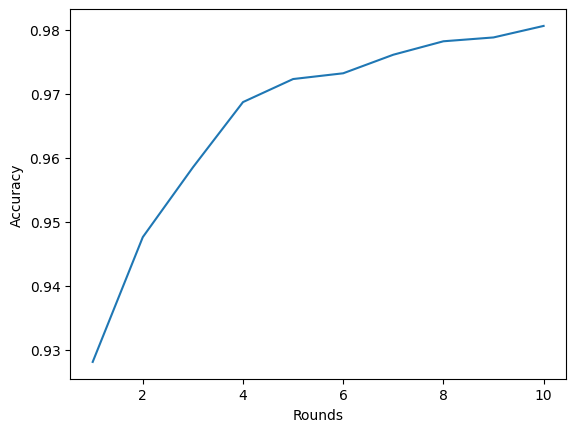

In [21]:
plt.plot(*zip(*history10.metrics_distributed['accuracy']))
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.show()

## Simulação com 15 rouds

In [22]:
history15 = fl.simulation.start_simulation(
    client_fn=client_fn_random,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=15),
    strategy=strategy,
)

INFO flwr 2023-04-17 19:35:58,909 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
2023-04-17 19:36:03,416	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-17 19:36:04,272 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 4845684327.0, 'object_store_memory': 2422842163.0, 'GPU': 1.0, 'CPU': 8.0, 'node:192.168.15.122': 1.0, 'accelerator_type:G': 1.0}
INFO flwr 2023-04-17 19:36:04,273 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-17 19:36:04,273 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-04-17 19:36:05,982 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-04-17 19:36:05,983 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-17 19:36:05,983 | server.py:101 | FL starting
DEBUG flwr 2023-04-17 19:36:05,984 | server.py:215 | fit_round 1: strategy s

(launch_and_fit pid=144951) 188/188 - 4s - loss: 0.5126 - accuracy: 0.8407 - 4s/epoch - 24ms/step
(launch_and_fit pid=144950) 188/188 - 7s - loss: 0.4877 - accuracy: 0.8472 - 7s/epoch - 35ms/step
(launch_and_fit pid=144946) 188/188 - 7s - loss: 0.4860 - accuracy: 0.8480 - 7s/epoch - 35ms/step
(launch_and_fit pid=144948) 188/188 - 7s - loss: 0.4931 - accuracy: 0.8463 - 7s/epoch - 36ms/step
(launch_and_fit pid=144947) 188/188 - 7s - loss: 0.4927 - accuracy: 0.8433 - 7s/epoch - 36ms/step
(launch_and_fit pid=144952) 188/188 - 7s - loss: 0.5113 - accuracy: 0.8390 - 7s/epoch - 36ms/step
(launch_and_fit pid=144953) 188/188 - 7s - loss: 0.4966 - accuracy: 0.8420 - 7s/epoch - 36ms/step
(launch_and_fit pid=144949) 188/188 - 7s - loss: 0.5091 - accuracy: 0.8425 - 7s/epoch - 36ms/step


DEBUG flwr 2023-04-17 19:36:16,779 | server.py:229 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-04-17 19:36:16,802 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-17 19:36:16,802 | server.py:165 | evaluate_round 1: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=144951) 188/188 - 5s - loss: 0.5061 - accuracy: 0.8402 - 5s/epoch - 25ms/step
(launch_and_evaluate pid=144951) 32/32 - 1s - loss: 0.2461 - accuracy: 0.9260 - 546ms/epoch - 17ms/step
(launch_and_evaluate pid=144952) 32/32 - 1s - loss: 0.2659 - accuracy: 0.9250 - 556ms/epoch - 17ms/step
(launch_and_evaluate pid=144953) 32/32 - 1s - loss: 0.2530 - accuracy: 0.9220 - 529ms/epoch - 17ms/step
(launch_and_evaluate pid=144947) 32/32 - 1s - loss: 0.2916 - accuracy: 0.9130 - 579ms/epoch - 18ms/step
(launch_and_evaluate pid=144950) 32/32 - 1s - loss: 0.2383 - accuracy: 0.9280 - 550ms/epoch - 17ms/step
(launch_and_evaluate pid=144946) 32/32 - 1s - loss: 0.2697 - accuracy: 0.9130 - 587ms/epoch - 18ms/step
(launch_and_evaluate pid=144948) 32/32 - 1s - loss: 0.2986 - accuracy: 0.9110 - 593ms/epoch - 19ms/step
(launch_and_evaluate pid=144949) 32/32 - 1s - loss: 0.2694 - accuracy: 0.9150 - 609ms/epoch - 19ms/step


DEBUG flwr 2023-04-17 19:36:18,363 | server.py:179 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:36:18,364 | server.py:215 | fit_round 2: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=144951) 32/32 - 0s - loss: 0.2526 - accuracy: 0.9180 - 220ms/epoch - 7ms/step
(launch_and_evaluate pid=144953) 32/32 - 0s - loss: 0.2869 - accuracy: 0.9180 - 221ms/epoch - 7ms/step
(launch_and_fit pid=144951) 188/188 - 6s - loss: 0.2446 - accuracy: 0.9255 - 6s/epoch - 34ms/step
(launch_and_fit pid=144952) 188/188 - 7s - loss: 0.2428 - accuracy: 0.9250 - 7s/epoch - 35ms/step
(launch_and_fit pid=144953) 188/188 - 6s - loss: 0.2489 - accuracy: 0.9222 - 6s/epoch - 35ms/step
(launch_and_fit pid=144947) 188/188 - 7s - loss: 0.2476 - accuracy: 0.9238 - 7s/epoch - 35ms/step
(launch_and_fit pid=144950) 188/188 - 7s - loss: 0.2369 - accuracy: 0.9257 - 7s/epoch - 35ms/step
(launch_and_fit pid=144948) 188/188 - 7s - loss: 0.2394 - accuracy: 0.9288 - 7s/epoch - 35ms/step
(launch_and_fit pid=144949) 188/188 - 7s - loss: 0.2373 - accuracy: 0.9263 - 7s/epoch - 35ms/step
(launch_and_fit pid=144946) 188/188 - 7s - loss: 0.2313 - accuracy: 0.9273 - 7s/epoch - 35ms/step


DEBUG flwr 2023-04-17 19:36:27,204 | server.py:229 | fit_round 2 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:36:27,222 | server.py:165 | evaluate_round 2: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=144953) 188/188 - 1s - loss: 0.2312 - accuracy: 0.9303 - 1s/epoch - 7ms/step
(launch_and_evaluate pid=144951) 32/32 - 1s - loss: 0.1623 - accuracy: 0.9420 - 509ms/epoch - 16ms/step
(launch_and_evaluate pid=144947) 32/32 - 1s - loss: 0.1470 - accuracy: 0.9500 - 511ms/epoch - 16ms/step
(launch_and_evaluate pid=144950) 32/32 - 0s - loss: 0.1320 - accuracy: 0.9580 - 495ms/epoch - 15ms/step
(launch_and_evaluate pid=144952) 32/32 - 1s - loss: 0.1572 - accuracy: 0.9430 - 529ms/epoch - 17ms/step
(launch_and_evaluate pid=144946) 32/32 - 1s - loss: 0.1384 - accuracy: 0.9580 - 526ms/epoch - 16ms/step
(launch_and_evaluate pid=144948) 32/32 - 1s - loss: 0.1490 - accuracy: 0.9550 - 528ms/epoch - 16ms/step
(launch_and_evaluate pid=144949) 32/32 - 0s - loss: 0.1713 - accuracy: 0.9460 - 499ms/epoch - 16ms/step
(launch_and_evaluate pid=144953) 32/32 - 1s - loss: 0.1498 - accuracy: 0.9480 - 528ms/epoch - 16ms/step


DEBUG flwr 2023-04-17 19:36:28,762 | server.py:179 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:36:28,762 | server.py:215 | fit_round 3: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=144947) 32/32 - 0s - loss: 0.1438 - accuracy: 0.9570 - 225ms/epoch - 7ms/step
(launch_and_evaluate pid=144950) 32/32 - 0s - loss: 0.1358 - accuracy: 0.9580 - 223ms/epoch - 7ms/step
(launch_and_fit pid=144951) 188/188 - 7s - loss: 0.1614 - accuracy: 0.9518 - 7s/epoch - 36ms/step
(launch_and_fit pid=144947) 188/188 - 7s - loss: 0.1727 - accuracy: 0.9478 - 7s/epoch - 36ms/step
(launch_and_fit pid=144950) 188/188 - 7s - loss: 0.1759 - accuracy: 0.9438 - 7s/epoch - 37ms/step
(launch_and_fit pid=144948) 188/188 - 7s - loss: 0.1667 - accuracy: 0.9513 - 7s/epoch - 37ms/step
(launch_and_fit pid=144952) 188/188 - 7s - loss: 0.1638 - accuracy: 0.9452 - 7s/epoch - 37ms/step
(launch_and_fit pid=144946) 188/188 - 7s - loss: 0.1778 - accuracy: 0.9433 - 7s/epoch - 37ms/step
(launch_and_fit pid=144949) 188/188 - 7s - loss: 0.1623 - accuracy: 0.9542 - 7s/epoch - 38ms/step
(launch_and_fit pid=144953) 188/188 - 7s - loss: 0.1866 - accuracy: 0.9458 - 7s/epoch - 38ms/step


DEBUG flwr 2023-04-17 19:36:37,713 | server.py:229 | fit_round 3 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:36:37,730 | server.py:165 | evaluate_round 3: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=144951) 188/188 - 1s - loss: 0.1615 - accuracy: 0.9523 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=144951) 32/32 - 1s - loss: 0.1376 - accuracy: 0.9580 - 506ms/epoch - 16ms/step
(launch_and_evaluate pid=144949) 32/32 - 1s - loss: 0.1060 - accuracy: 0.9720 - 516ms/epoch - 16ms/step
(launch_and_evaluate pid=144947) 32/32 - 1s - loss: 0.1209 - accuracy: 0.9670 - 526ms/epoch - 16ms/step
(launch_and_evaluate pid=144950) 32/32 - 0s - loss: 0.1265 - accuracy: 0.9650 - 499ms/epoch - 16ms/step
(launch_and_evaluate pid=144952) 32/32 - 1s - loss: 0.1139 - accuracy: 0.9680 - 553ms/epoch - 17ms/step
(launch_and_evaluate pid=144946) 32/32 - 1s - loss: 0.1040 - accuracy: 0.9730 - 525ms/epoch - 16ms/step
(launch_and_evaluate pid=144948) 32/32 - 1s - loss: 0.1247 - accuracy: 0.9520 - 520ms/epoch - 16ms/step
(launch_and_evaluate pid=144953) 32/32 - 1s - loss: 0.1154 - accuracy: 0.9640 - 520ms/epoch - 16ms/step


DEBUG flwr 2023-04-17 19:36:39,251 | server.py:179 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:36:39,251 | server.py:215 | fit_round 4: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=144951) 32/32 - 0s - loss: 0.0934 - accuracy: 0.9720 - 224ms/epoch - 7ms/step
(launch_and_evaluate pid=144949) 32/32 - 0s - loss: 0.1090 - accuracy: 0.9630 - 229ms/epoch - 7ms/step
(launch_and_fit pid=144951) 188/188 - 6s - loss: 0.1332 - accuracy: 0.9592 - 6s/epoch - 34ms/step
(launch_and_fit pid=144950) 188/188 - 6s - loss: 0.1355 - accuracy: 0.9612 - 6s/epoch - 33ms/step
(launch_and_fit pid=144952) 188/188 - 6s - loss: 0.1389 - accuracy: 0.9580 - 6s/epoch - 34ms/step
(launch_and_fit pid=144946) 188/188 - 6s - loss: 0.1307 - accuracy: 0.9610 - 6s/epoch - 34ms/step
(launch_and_fit pid=144947) 188/188 - 6s - loss: 0.1398 - accuracy: 0.9612 - 6s/epoch - 34ms/step
(launch_and_fit pid=144949) 188/188 - 6s - loss: 0.1371 - accuracy: 0.9587 - 6s/epoch - 35ms/step
(launch_and_fit pid=144948) 188/188 - 7s - loss: 0.1360 - accuracy: 0.9583 - 7s/epoch - 35ms/step
(launch_and_fit pid=144953) 188/188 - 6s - loss: 0.1323 - accuracy: 0.9602 - 6s/epoch - 34ms/step


DEBUG flwr 2023-04-17 19:36:47,718 | server.py:229 | fit_round 4 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:36:47,735 | server.py:165 | evaluate_round 4: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=144946) 188/188 - 1s - loss: 0.1476 - accuracy: 0.9550 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=144946) 32/32 - 1s - loss: 0.1101 - accuracy: 0.9670 - 516ms/epoch - 16ms/step
(launch_and_evaluate pid=144953) 32/32 - 1s - loss: 0.1029 - accuracy: 0.9740 - 526ms/epoch - 16ms/step
(launch_and_evaluate pid=144951) 32/32 - 1s - loss: 0.0793 - accuracy: 0.9760 - 537ms/epoch - 17ms/step
(launch_and_evaluate pid=144947) 32/32 - 1s - loss: 0.0881 - accuracy: 0.9700 - 545ms/epoch - 17ms/step
(launch_and_evaluate pid=144950) 32/32 - 1s - loss: 0.0971 - accuracy: 0.9680 - 550ms/epoch - 17ms/step
(launch_and_evaluate pid=144952) 32/32 - 1s - loss: 0.0738 - accuracy: 0.9800 - 516ms/epoch - 16ms/step
(launch_and_evaluate pid=144948) 32/32 - 1s - loss: 0.0903 - accuracy: 0.9730 - 559ms/epoch - 17ms/step
(launch_and_evaluate pid=144949) 32/32 - 1s - loss: 0.0848 - accuracy: 0.9730 - 544ms/epoch - 17ms/step


DEBUG flwr 2023-04-17 19:36:49,268 | server.py:179 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:36:49,268 | server.py:215 | fit_round 5: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=144946) 32/32 - 0s - loss: 0.0841 - accuracy: 0.9730 - 219ms/epoch - 7ms/step
(launch_and_evaluate pid=144953) 32/32 - 0s - loss: 0.0956 - accuracy: 0.9720 - 219ms/epoch - 7ms/step
(launch_and_fit pid=144948) 188/188 - 6s - loss: 0.1042 - accuracy: 0.9690 - 6s/epoch - 34ms/step
(launch_and_fit pid=144951) 188/188 - 7s - loss: 0.1188 - accuracy: 0.9638 - 7s/epoch - 35ms/step
(launch_and_fit pid=144950) 188/188 - 7s - loss: 0.1117 - accuracy: 0.9682 - 7s/epoch - 35ms/step
(launch_and_fit pid=144953) 188/188 - 7s - loss: 0.1271 - accuracy: 0.9617 - 7s/epoch - 35ms/step
(launch_and_fit pid=144947) 188/188 - 7s - loss: 0.1221 - accuracy: 0.9670 - 7s/epoch - 35ms/step
(launch_and_fit pid=144949) 188/188 - 7s - loss: 0.1213 - accuracy: 0.9618 - 7s/epoch - 35ms/step
(launch_and_fit pid=144946) 188/188 - 7s - loss: 0.1145 - accuracy: 0.9670 - 7s/epoch - 36ms/step
(launch_and_fit pid=144952) 188/188 - 7s - loss: 0.1068 - accuracy: 0.9677 - 7s/epoch - 36ms/step


DEBUG flwr 2023-04-17 19:36:57,877 | server.py:229 | fit_round 5 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:36:57,892 | server.py:165 | evaluate_round 5: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=144948) 188/188 - 1s - loss: 0.1124 - accuracy: 0.9670 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=144948) 32/32 - 1s - loss: 0.0823 - accuracy: 0.9760 - 505ms/epoch - 16ms/step
(launch_and_evaluate pid=144951) 32/32 - 1s - loss: 0.0880 - accuracy: 0.9690 - 525ms/epoch - 16ms/step
(launch_and_evaluate pid=144950) 32/32 - 1s - loss: 0.0941 - accuracy: 0.9740 - 575ms/epoch - 18ms/step
(launch_and_evaluate pid=144952) 32/32 - 1s - loss: 0.0878 - accuracy: 0.9740 - 575ms/epoch - 18ms/step
(launch_and_evaluate pid=144953) 32/32 - 1s - loss: 0.0868 - accuracy: 0.9780 - 544ms/epoch - 17ms/step
(launch_and_evaluate pid=144947) 32/32 - 1s - loss: 0.0787 - accuracy: 0.9760 - 588ms/epoch - 18ms/step
(launch_and_evaluate pid=144946) 32/32 - 1s - loss: 0.0853 - accuracy: 0.9720 - 609ms/epoch - 19ms/step
(launch_and_evaluate pid=144949) 32/32 - 1s - loss: 0.0964 - accuracy: 0.9660 - 569ms/epoch - 18ms/step


DEBUG flwr 2023-04-17 19:36:59,517 | server.py:179 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:36:59,517 | server.py:215 | fit_round 6: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=144948) 32/32 - 0s - loss: 0.0924 - accuracy: 0.9710 - 231ms/epoch - 7ms/step
(launch_and_evaluate pid=144953) 32/32 - 0s - loss: 0.1046 - accuracy: 0.9670 - 239ms/epoch - 7ms/step
(launch_and_fit pid=144951) 188/188 - 6s - loss: 0.0953 - accuracy: 0.9707 - 6s/epoch - 34ms/step
(launch_and_fit pid=144952) 188/188 - 7s - loss: 0.0957 - accuracy: 0.9700 - 7s/epoch - 35ms/step
(launch_and_fit pid=144946) 188/188 - 7s - loss: 0.1103 - accuracy: 0.9668 - 7s/epoch - 36ms/step
(launch_and_fit pid=144948) 188/188 - 7s - loss: 0.1035 - accuracy: 0.9703 - 7s/epoch - 36ms/step
(launch_and_fit pid=144949) 188/188 - 7s - loss: 0.1026 - accuracy: 0.9692 - 7s/epoch - 37ms/step
(launch_and_fit pid=144953) 188/188 - 7s - loss: 0.1082 - accuracy: 0.9652 - 7s/epoch - 37ms/step
(launch_and_fit pid=144950) 188/188 - 7s - loss: 0.1032 - accuracy: 0.9687 - 7s/epoch - 38ms/step
(launch_and_fit pid=144947) 188/188 - 7s - loss: 0.0909 - accuracy: 0.9735 - 7s/epoch - 38ms/step


DEBUG flwr 2023-04-17 19:37:08,564 | server.py:229 | fit_round 6 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:37:08,581 | server.py:165 | evaluate_round 6: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=144951) 188/188 - 1s - loss: 0.1051 - accuracy: 0.9690 - 1s/epoch - 7ms/step
(launch_and_evaluate pid=144950) 32/32 - 1s - loss: 0.0640 - accuracy: 0.9820 - 544ms/epoch - 17ms/step
(launch_and_evaluate pid=144948) 32/32 - 1s - loss: 0.0539 - accuracy: 0.9860 - 601ms/epoch - 19ms/step
(launch_and_evaluate pid=144953) 32/32 - 1s - loss: 0.0816 - accuracy: 0.9730 - 567ms/epoch - 18ms/step
(launch_and_evaluate pid=144951) 32/32 - 1s - loss: 0.0589 - accuracy: 0.9860 - 727ms/epoch - 23ms/step
(launch_and_evaluate pid=144947) 32/32 - 1s - loss: 0.0844 - accuracy: 0.9730 - 596ms/epoch - 19ms/step
(launch_and_evaluate pid=144952) 32/32 - 1s - loss: 0.0702 - accuracy: 0.9820 - 636ms/epoch - 20ms/step
(launch_and_evaluate pid=144946) 32/32 - 1s - loss: 0.0715 - accuracy: 0.9800 - 650ms/epoch - 20ms/step
(launch_and_evaluate pid=144949) 32/32 - 1s - loss: 0.0932 - accuracy: 0.9740 - 572ms/epoch - 18ms/step


DEBUG flwr 2023-04-17 19:37:10,294 | server.py:179 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:37:10,295 | server.py:215 | fit_round 7: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=144950) 32/32 - 0s - loss: 0.0728 - accuracy: 0.9790 - 218ms/epoch - 7ms/step
(launch_and_evaluate pid=144948) 32/32 - 0s - loss: 0.0598 - accuracy: 0.9810 - 220ms/epoch - 7ms/step
(launch_and_fit pid=144950) 188/188 - 7s - loss: 0.0958 - accuracy: 0.9722 - 7s/epoch - 38ms/step
(launch_and_fit pid=144951) 188/188 - 7s - loss: 0.0904 - accuracy: 0.9733 - 7s/epoch - 39ms/step
(launch_and_fit pid=144949) 188/188 - 7s - loss: 0.0784 - accuracy: 0.9755 - 7s/epoch - 39ms/step
(launch_and_fit pid=144948) 188/188 - 8s - loss: 0.0889 - accuracy: 0.9735 - 8s/epoch - 40ms/step
(launch_and_fit pid=144947) 188/188 - 8s - loss: 0.0809 - accuracy: 0.9767 - 8s/epoch - 41ms/step
(launch_and_fit pid=144953) 188/188 - 8s - loss: 0.0904 - accuracy: 0.9720 - 8s/epoch - 41ms/step
(launch_and_fit pid=144952) 188/188 - 8s - loss: 0.0974 - accuracy: 0.9710 - 8s/epoch - 41ms/step
(launch_and_fit pid=144946) 188/188 - 8s - loss: 0.0938 - accuracy: 0.9742 - 8s/epoch - 41ms/step


DEBUG flwr 2023-04-17 19:37:19,917 | server.py:229 | fit_round 7 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:37:19,932 | server.py:165 | evaluate_round 7: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=144950) 188/188 - 1s - loss: 0.0826 - accuracy: 0.9730 - 1s/epoch - 7ms/step
(launch_and_evaluate pid=144950) 32/32 - 0s - loss: 0.0683 - accuracy: 0.9760 - 394ms/epoch - 12ms/step
(launch_and_evaluate pid=144951) 32/32 - 1s - loss: 0.0692 - accuracy: 0.9820 - 605ms/epoch - 19ms/step
(launch_and_evaluate pid=144947) 32/32 - 1s - loss: 0.0782 - accuracy: 0.9760 - 668ms/epoch - 21ms/step
(launch_and_evaluate pid=144952) 32/32 - 1s - loss: 0.0630 - accuracy: 0.9760 - 629ms/epoch - 20ms/step
(launch_and_evaluate pid=144946) 32/32 - 1s - loss: 0.0699 - accuracy: 0.9750 - 645ms/epoch - 20ms/step
(launch_and_evaluate pid=144948) 32/32 - 1s - loss: 0.0451 - accuracy: 0.9860 - 649ms/epoch - 20ms/step
(launch_and_evaluate pid=144949) 32/32 - 1s - loss: 0.0740 - accuracy: 0.9730 - 659ms/epoch - 21ms/step
(launch_and_evaluate pid=144953) 32/32 - 1s - loss: 0.0675 - accuracy: 0.9790 - 627ms/epoch - 20ms/step
(launch_and_evaluate pid=144950) 32/32 - 0s - loss: 0.0756 - accuracy: 

DEBUG flwr 2023-04-17 19:37:21,973 | server.py:179 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:37:21,974 | server.py:215 | fit_round 8: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=144951) 32/32 - 0s - loss: 0.0743 - accuracy: 0.9750 - 191ms/epoch - 6ms/step
(launch_and_fit pid=144946) 188/188 - 7s - loss: 0.0864 - accuracy: 0.9737 - 7s/epoch - 37ms/step
(launch_and_fit pid=144953) 188/188 - 7s - loss: 0.0877 - accuracy: 0.9730 - 7s/epoch - 37ms/step
(launch_and_fit pid=144950) 188/188 - 7s - loss: 0.0784 - accuracy: 0.9755 - 7s/epoch - 37ms/step
(launch_and_fit pid=144951) 188/188 - 7s - loss: 0.0845 - accuracy: 0.9740 - 7s/epoch - 39ms/step
(launch_and_fit pid=144949) 188/188 - 7s - loss: 0.0733 - accuracy: 0.9775 - 7s/epoch - 39ms/step
(launch_and_fit pid=144947) 188/188 - 7s - loss: 0.0843 - accuracy: 0.9730 - 7s/epoch - 40ms/step
(launch_and_fit pid=144952) 188/188 - 7s - loss: 0.0717 - accuracy: 0.9782 - 7s/epoch - 40ms/step
(launch_and_fit pid=144948) 188/188 - 7s - loss: 0.0724 - accuracy: 0.9785 - 7s/epoch - 40ms/step


DEBUG flwr 2023-04-17 19:37:31,560 | server.py:229 | fit_round 8 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:37:31,575 | server.py:165 | evaluate_round 8: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=144946) 188/188 - 1s - loss: 0.0713 - accuracy: 0.9788 - 1s/epoch - 7ms/step
(launch_and_evaluate pid=144947) 32/32 - 1s - loss: 0.0492 - accuracy: 0.9820 - 561ms/epoch - 18ms/step
(launch_and_evaluate pid=144952) 32/32 - 1s - loss: 0.0692 - accuracy: 0.9790 - 568ms/epoch - 18ms/step
(launch_and_evaluate pid=144946) 32/32 - 1s - loss: 0.0557 - accuracy: 0.9800 - 533ms/epoch - 17ms/step
(launch_and_evaluate pid=144948) 32/32 - 1s - loss: 0.0613 - accuracy: 0.9770 - 542ms/epoch - 17ms/step
(launch_and_evaluate pid=144949) 32/32 - 1s - loss: 0.0641 - accuracy: 0.9760 - 581ms/epoch - 18ms/step
(launch_and_evaluate pid=144953) 32/32 - 1s - loss: 0.0560 - accuracy: 0.9840 - 538ms/epoch - 17ms/step
(launch_and_evaluate pid=144951) 32/32 - 1s - loss: 0.0514 - accuracy: 0.9850 - 519ms/epoch - 16ms/step
(launch_and_evaluate pid=144950) 32/32 - 1s - loss: 0.0528 - accuracy: 0.9820 - 815ms/epoch - 25ms/step


DEBUG flwr 2023-04-17 19:37:33,757 | server.py:179 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:37:33,757 | server.py:215 | fit_round 9: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=144946) 32/32 - 0s - loss: 0.0842 - accuracy: 0.9730 - 228ms/epoch - 7ms/step
(launch_and_evaluate pid=144948) 32/32 - 0s - loss: 0.0579 - accuracy: 0.9800 - 398ms/epoch - 12ms/step
(launch_and_fit pid=144946) 188/188 - 7s - loss: 0.0679 - accuracy: 0.9785 - 7s/epoch - 39ms/step
(launch_and_fit pid=144947) 188/188 - 7s - loss: 0.0684 - accuracy: 0.9795 - 7s/epoch - 39ms/step
(launch_and_fit pid=144952) 188/188 - 7s - loss: 0.0803 - accuracy: 0.9738 - 7s/epoch - 39ms/step
(launch_and_fit pid=144949) 188/188 - 7s - loss: 0.0686 - accuracy: 0.9802 - 7s/epoch - 39ms/step
(launch_and_fit pid=144951) 188/188 - 8s - loss: 0.0741 - accuracy: 0.9767 - 8s/epoch - 40ms/step
(launch_and_fit pid=144950) 188/188 - 8s - loss: 0.0785 - accuracy: 0.9770 - 8s/epoch - 40ms/step
(launch_and_fit pid=144948) 188/188 - 8s - loss: 0.0839 - accuracy: 0.9733 - 8s/epoch - 40ms/step
(launch_and_fit pid=144953) 188/188 - 8s - loss: 0.0736 - accuracy: 0.9773 - 8s/epoch - 41ms/step


DEBUG flwr 2023-04-17 19:37:43,621 | server.py:229 | fit_round 9 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:37:43,637 | server.py:165 | evaluate_round 9: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=144946) 188/188 - 1s - loss: 0.0676 - accuracy: 0.9782 - 1s/epoch - 8ms/step
(launch_and_evaluate pid=144951) 32/32 - 1s - loss: 0.0700 - accuracy: 0.9780 - 584ms/epoch - 18ms/step
(launch_and_evaluate pid=144947) 32/32 - 1s - loss: 0.0389 - accuracy: 0.9880 - 512ms/epoch - 16ms/step
(launch_and_evaluate pid=144950) 32/32 - 1s - loss: 0.0493 - accuracy: 0.9820 - 518ms/epoch - 16ms/step
(launch_and_evaluate pid=144952) 32/32 - 1s - loss: 0.0642 - accuracy: 0.9760 - 530ms/epoch - 17ms/step
(launch_and_evaluate pid=144946) 32/32 - 1s - loss: 0.0455 - accuracy: 0.9820 - 555ms/epoch - 17ms/step
(launch_and_evaluate pid=144948) 32/32 - 1s - loss: 0.0680 - accuracy: 0.9760 - 564ms/epoch - 18ms/step
(launch_and_evaluate pid=144949) 32/32 - 1s - loss: 0.0594 - accuracy: 0.9780 - 557ms/epoch - 17ms/step
(launch_and_evaluate pid=144953) 32/32 - 1s - loss: 0.0733 - accuracy: 0.9770 - 563ms/epoch - 18ms/step


DEBUG flwr 2023-04-17 19:37:45,198 | server.py:179 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:37:45,199 | server.py:215 | fit_round 10: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=144950) 32/32 - 0s - loss: 0.0465 - accuracy: 0.9840 - 235ms/epoch - 7ms/step
(launch_and_evaluate pid=144946) 32/32 - 0s - loss: 0.0695 - accuracy: 0.9750 - 232ms/epoch - 7ms/step
(launch_and_fit pid=144949) 188/188 - 7s - loss: 0.0680 - accuracy: 0.9807 - 7s/epoch - 37ms/step
(launch_and_fit pid=144946) 188/188 - 7s - loss: 0.0711 - accuracy: 0.9790 - 7s/epoch - 37ms/step
(launch_and_fit pid=144953) 188/188 - 7s - loss: 0.0637 - accuracy: 0.9812 - 7s/epoch - 39ms/step
(launch_and_fit pid=144952) 188/188 - 8s - loss: 0.0613 - accuracy: 0.9782 - 8s/epoch - 40ms/step
(launch_and_fit pid=144948) 188/188 - 7s - loss: 0.0603 - accuracy: 0.9832 - 7s/epoch - 40ms/step
(launch_and_fit pid=144951) 188/188 - 8s - loss: 0.0697 - accuracy: 0.9797 - 8s/epoch - 41ms/step
(launch_and_fit pid=144947) 188/188 - 8s - loss: 0.0700 - accuracy: 0.9787 - 8s/epoch - 41ms/step
(launch_and_fit pid=144950) 188/188 - 8s - loss: 0.0704 - accuracy: 0.9788 - 8s/epoch - 41ms/step


DEBUG flwr 2023-04-17 19:37:55,068 | server.py:229 | fit_round 10 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:37:55,083 | server.py:165 | evaluate_round 10: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=144949) 188/188 - 2s - loss: 0.0665 - accuracy: 0.9802 - 2s/epoch - 9ms/step
(launch_and_evaluate pid=144951) 32/32 - 1s - loss: 0.0565 - accuracy: 0.9800 - 565ms/epoch - 18ms/step
(launch_and_evaluate pid=144947) 32/32 - 1s - loss: 0.0499 - accuracy: 0.9840 - 612ms/epoch - 19ms/step
(launch_and_evaluate pid=144950) 32/32 - 1s - loss: 0.0504 - accuracy: 0.9830 - 601ms/epoch - 19ms/step
(launch_and_evaluate pid=144949) 32/32 - 1s - loss: 0.0744 - accuracy: 0.9730 - 574ms/epoch - 18ms/step
(launch_and_evaluate pid=144953) 32/32 - 1s - loss: 0.0615 - accuracy: 0.9740 - 554ms/epoch - 17ms/step
(launch_and_evaluate pid=144952) 32/32 - 0s - loss: 0.0471 - accuracy: 0.9840 - 412ms/epoch - 13ms/step
(launch_and_evaluate pid=144946) 32/32 - 1s - loss: 0.0608 - accuracy: 0.9770 - 543ms/epoch - 17ms/step
(launch_and_evaluate pid=144948) 32/32 - 0s - loss: 0.0801 - accuracy: 0.9720 - 475ms/epoch - 15ms/step


DEBUG flwr 2023-04-17 19:37:56,775 | server.py:179 | evaluate_round 10 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:37:56,776 | server.py:215 | fit_round 11: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=144951) 32/32 - 0s - loss: 0.0541 - accuracy: 0.9790 - 202ms/epoch - 6ms/step
(launch_and_evaluate pid=144953) 32/32 - 0s - loss: 0.0540 - accuracy: 0.9810 - 218ms/epoch - 7ms/step
(launch_and_fit pid=144948) 188/188 - 6s - loss: 0.0615 - accuracy: 0.9825 - 6s/epoch - 33ms/step
(launch_and_fit pid=144951) 188/188 - 6s - loss: 0.0644 - accuracy: 0.9785 - 6s/epoch - 34ms/step
(launch_and_fit pid=144947) 188/188 - 6s - loss: 0.0684 - accuracy: 0.9808 - 6s/epoch - 33ms/step
(launch_and_fit pid=144952) 188/188 - 6s - loss: 0.0635 - accuracy: 0.9817 - 6s/epoch - 34ms/step
(launch_and_fit pid=144953) 188/188 - 6s - loss: 0.0562 - accuracy: 0.9843 - 6s/epoch - 34ms/step
(launch_and_fit pid=144950) 188/188 - 6s - loss: 0.0651 - accuracy: 0.9812 - 6s/epoch - 34ms/step
(launch_and_fit pid=144946) 188/188 - 6s - loss: 0.0653 - accuracy: 0.9803 - 6s/epoch - 34ms/step
(launch_and_fit pid=144949) 188/188 - 6s - loss: 0.0664 - accuracy: 0.9803 - 6s/epoch - 34ms/step


DEBUG flwr 2023-04-17 19:38:05,110 | server.py:229 | fit_round 11 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:38:05,125 | server.py:165 | evaluate_round 11: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=144948) 188/188 - 1s - loss: 0.0628 - accuracy: 0.9805 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=144951) 32/32 - 1s - loss: 0.0491 - accuracy: 0.9830 - 509ms/epoch - 16ms/step
(launch_and_evaluate pid=144950) 32/32 - 0s - loss: 0.0673 - accuracy: 0.9800 - 498ms/epoch - 16ms/step
(launch_and_evaluate pid=144952) 32/32 - 1s - loss: 0.0477 - accuracy: 0.9800 - 506ms/epoch - 16ms/step
(launch_and_evaluate pid=144946) 32/32 - 1s - loss: 0.0654 - accuracy: 0.9760 - 532ms/epoch - 17ms/step
(launch_and_evaluate pid=144948) 32/32 - 1s - loss: 0.0495 - accuracy: 0.9810 - 533ms/epoch - 17ms/step
(launch_and_evaluate pid=144949) 32/32 - 0s - loss: 0.0437 - accuracy: 0.9850 - 497ms/epoch - 16ms/step
(launch_and_evaluate pid=144953) 32/32 - 1s - loss: 0.0507 - accuracy: 0.9780 - 519ms/epoch - 16ms/step
(launch_and_evaluate pid=144947) 32/32 - 1s - loss: 0.0373 - accuracy: 0.9880 - 516ms/epoch - 16ms/step


DEBUG flwr 2023-04-17 19:38:06,596 | server.py:179 | evaluate_round 11 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:38:06,596 | server.py:215 | fit_round 12: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=144950) 32/32 - 0s - loss: 0.0739 - accuracy: 0.9760 - 216ms/epoch - 7ms/step
(launch_and_evaluate pid=144949) 32/32 - 0s - loss: 0.0541 - accuracy: 0.9840 - 216ms/epoch - 7ms/step
(launch_and_fit pid=144947) 188/188 - 7s - loss: 0.0548 - accuracy: 0.9842 - 7s/epoch - 36ms/step
(launch_and_fit pid=144950) 188/188 - 7s - loss: 0.0531 - accuracy: 0.9840 - 7s/epoch - 38ms/step
(launch_and_fit pid=144949) 188/188 - 7s - loss: 0.0561 - accuracy: 0.9835 - 7s/epoch - 38ms/step
(launch_and_fit pid=144946) 188/188 - 7s - loss: 0.0639 - accuracy: 0.9822 - 7s/epoch - 38ms/step
(launch_and_fit pid=144951) 188/188 - 7s - loss: 0.0538 - accuracy: 0.9823 - 7s/epoch - 39ms/step
(launch_and_fit pid=144952) 188/188 - 7s - loss: 0.0516 - accuracy: 0.9847 - 7s/epoch - 38ms/step
(launch_and_fit pid=144948) 188/188 - 7s - loss: 0.0548 - accuracy: 0.9838 - 7s/epoch - 39ms/step
(launch_and_fit pid=144953) 188/188 - 7s - loss: 0.0621 - accuracy: 0.9833 - 7s/epoch - 39ms/step


DEBUG flwr 2023-04-17 19:38:15,675 | server.py:229 | fit_round 12 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:38:15,691 | server.py:165 | evaluate_round 12: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=144947) 188/188 - 1s - loss: 0.0582 - accuracy: 0.9830 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=144948) 32/32 - 1s - loss: 0.0505 - accuracy: 0.9850 - 515ms/epoch - 16ms/step
(launch_and_evaluate pid=144953) 32/32 - 1s - loss: 0.0559 - accuracy: 0.9850 - 524ms/epoch - 16ms/step
(launch_and_evaluate pid=144951) 32/32 - 1s - loss: 0.0422 - accuracy: 0.9830 - 532ms/epoch - 17ms/step
(launch_and_evaluate pid=144947) 32/32 - 1s - loss: 0.0722 - accuracy: 0.9720 - 542ms/epoch - 17ms/step
(launch_and_evaluate pid=144950) 32/32 - 1s - loss: 0.0447 - accuracy: 0.9830 - 510ms/epoch - 16ms/step
(launch_and_evaluate pid=144952) 32/32 - 1s - loss: 0.0581 - accuracy: 0.9830 - 533ms/epoch - 17ms/step
(launch_and_evaluate pid=144946) 32/32 - 1s - loss: 0.0737 - accuracy: 0.9710 - 502ms/epoch - 16ms/step
(launch_and_evaluate pid=144949) 32/32 - 1s - loss: 0.0445 - accuracy: 0.9850 - 516ms/epoch - 16ms/step


DEBUG flwr 2023-04-17 19:38:17,182 | server.py:179 | evaluate_round 12 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:38:17,183 | server.py:215 | fit_round 13: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=144948) 32/32 - 0s - loss: 0.0537 - accuracy: 0.9800 - 212ms/epoch - 7ms/step
(launch_and_evaluate pid=144953) 32/32 - 0s - loss: 0.0736 - accuracy: 0.9740 - 218ms/epoch - 7ms/step
(launch_and_fit pid=144949) 188/188 - 6s - loss: 0.0542 - accuracy: 0.9832 - 6s/epoch - 33ms/step
(launch_and_fit pid=144948) 188/188 - 6s - loss: 0.0554 - accuracy: 0.9845 - 6s/epoch - 33ms/step
(launch_and_fit pid=144950) 188/188 - 6s - loss: 0.0512 - accuracy: 0.9838 - 6s/epoch - 34ms/step
(launch_and_fit pid=144946) 188/188 - 6s - loss: 0.0573 - accuracy: 0.9815 - 6s/epoch - 34ms/step
(launch_and_fit pid=144951) 188/188 - 6s - loss: 0.0510 - accuracy: 0.9867 - 6s/epoch - 35ms/step
(launch_and_fit pid=144952) 188/188 - 7s - loss: 0.0542 - accuracy: 0.9825 - 7s/epoch - 35ms/step
(launch_and_fit pid=144953) 188/188 - 6s - loss: 0.0576 - accuracy: 0.9822 - 6s/epoch - 35ms/step
(launch_and_fit pid=144947) 188/188 - 7s - loss: 0.0552 - accuracy: 0.9852 - 7s/epoch - 35ms/step


DEBUG flwr 2023-04-17 19:38:25,527 | server.py:229 | fit_round 13 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:38:25,543 | server.py:165 | evaluate_round 13: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=144949) 188/188 - 1s - loss: 0.0501 - accuracy: 0.9857 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=144951) 32/32 - 1s - loss: 0.0487 - accuracy: 0.9800 - 568ms/epoch - 18ms/step
(launch_and_evaluate pid=144947) 32/32 - 1s - loss: 0.0596 - accuracy: 0.9760 - 615ms/epoch - 19ms/step
(launch_and_evaluate pid=144950) 32/32 - 1s - loss: 0.0450 - accuracy: 0.9850 - 565ms/epoch - 18ms/step
(launch_and_evaluate pid=144952) 32/32 - 1s - loss: 0.0591 - accuracy: 0.9730 - 577ms/epoch - 18ms/step
(launch_and_evaluate pid=144946) 32/32 - 1s - loss: 0.0297 - accuracy: 0.9900 - 574ms/epoch - 18ms/step
(launch_and_evaluate pid=144949) 32/32 - 1s - loss: 0.0504 - accuracy: 0.9800 - 590ms/epoch - 18ms/step
(launch_and_evaluate pid=144953) 32/32 - 1s - loss: 0.0516 - accuracy: 0.9820 - 585ms/epoch - 18ms/step
(launch_and_evaluate pid=144953) 32/32 - 0s - loss: 0.0410 - accuracy: 0.9870 - 211ms/epoch - 7ms/step
(launch_and_evaluate pid=144953) 32/32 - 0s - loss: 0.0500 - accuracy: 0

DEBUG flwr 2023-04-17 19:38:30,018 | server.py:179 | evaluate_round 13 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:38:30,019 | server.py:215 | fit_round 14: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=149107) 32/32 - 0s - loss: 0.0441 - accuracy: 0.9820 - 238ms/epoch - 7ms/step
(launch_and_fit pid=144949) 188/188 - 7s - loss: 0.0448 - accuracy: 0.9862 - 7s/epoch - 35ms/step
(launch_and_fit pid=149107) 188/188 - 7s - loss: 0.0483 - accuracy: 0.9870 - 7s/epoch - 37ms/step
(launch_and_fit pid=144947) 188/188 - 7s - loss: 0.0522 - accuracy: 0.9823 - 7s/epoch - 37ms/step
(launch_and_fit pid=144951) 188/188 - 7s - loss: 0.0542 - accuracy: 0.9837 - 7s/epoch - 37ms/step
(launch_and_fit pid=144950) 188/188 - 7s - loss: 0.0559 - accuracy: 0.9808 - 7s/epoch - 37ms/step
(launch_and_fit pid=144952) 188/188 - 7s - loss: 0.0585 - accuracy: 0.9825 - 7s/epoch - 37ms/step
(launch_and_fit pid=144946) 188/188 - 7s - loss: 0.0464 - accuracy: 0.9865 - 7s/epoch - 38ms/step
(launch_and_fit pid=144953) 188/188 - 7s - loss: 0.0483 - accuracy: 0.9840 - 7s/epoch - 38ms/step


DEBUG flwr 2023-04-17 19:38:38,843 | server.py:229 | fit_round 14 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:38:38,859 | server.py:165 | evaluate_round 14: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=144949) 188/188 - 1s - loss: 0.0505 - accuracy: 0.9840 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=144950) 32/32 - 0s - loss: 0.0456 - accuracy: 0.9850 - 489ms/epoch - 15ms/step
(launch_and_evaluate pid=144949) 32/32 - 1s - loss: 0.0505 - accuracy: 0.9860 - 520ms/epoch - 16ms/step
(launch_and_evaluate pid=144951) 32/32 - 1s - loss: 0.0487 - accuracy: 0.9810 - 518ms/epoch - 16ms/step
(launch_and_evaluate pid=144947) 32/32 - 1s - loss: 0.0582 - accuracy: 0.9800 - 554ms/epoch - 17ms/step
(launch_and_evaluate pid=144952) 32/32 - 1s - loss: 0.0460 - accuracy: 0.9820 - 534ms/epoch - 17ms/step
(launch_and_evaluate pid=144946) 32/32 - 1s - loss: 0.0329 - accuracy: 0.9890 - 555ms/epoch - 17ms/step
(launch_and_evaluate pid=144953) 32/32 - 1s - loss: 0.0488 - accuracy: 0.9790 - 564ms/epoch - 18ms/step
(launch_and_evaluate pid=149107) 32/32 - 1s - loss: 0.0367 - accuracy: 0.9840 - 536ms/epoch - 17ms/step


DEBUG flwr 2023-04-17 19:38:40,408 | server.py:179 | evaluate_round 14 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:38:40,408 | server.py:215 | fit_round 15: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=144950) 32/32 - 0s - loss: 0.0749 - accuracy: 0.9790 - 221ms/epoch - 7ms/step
(launch_and_evaluate pid=144949) 32/32 - 0s - loss: 0.0354 - accuracy: 0.9920 - 221ms/epoch - 7ms/step
(launch_and_fit pid=144953) 188/188 - 6s - loss: 0.0527 - accuracy: 0.9842 - 6s/epoch - 35ms/step
(launch_and_fit pid=144947) 188/188 - 7s - loss: 0.0492 - accuracy: 0.9845 - 7s/epoch - 35ms/step
(launch_and_fit pid=144952) 188/188 - 7s - loss: 0.0479 - accuracy: 0.9865 - 7s/epoch - 35ms/step
(launch_and_fit pid=144949) 188/188 - 7s - loss: 0.0493 - accuracy: 0.9858 - 7s/epoch - 37ms/step
(launch_and_fit pid=149107) 188/188 - 7s - loss: 0.0463 - accuracy: 0.9855 - 7s/epoch - 36ms/step
(launch_and_fit pid=144951) 188/188 - 7s - loss: 0.0505 - accuracy: 0.9838 - 7s/epoch - 37ms/step
(launch_and_fit pid=144950) 188/188 - 7s - loss: 0.0483 - accuracy: 0.9868 - 7s/epoch - 37ms/step
(launch_and_fit pid=144946) 188/188 - 7s - loss: 0.0537 - accuracy: 0.9822 - 7s/epoch - 36ms/step


DEBUG flwr 2023-04-17 19:38:49,139 | server.py:229 | fit_round 15 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:38:49,155 | server.py:165 | evaluate_round 15: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=144953) 188/188 - 1s - loss: 0.0479 - accuracy: 0.9863 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=144951) 32/32 - 1s - loss: 0.0362 - accuracy: 0.9890 - 545ms/epoch - 17ms/step
(launch_and_evaluate pid=144947) 32/32 - 1s - loss: 0.0529 - accuracy: 0.9810 - 562ms/epoch - 18ms/step
(launch_and_evaluate pid=144946) 32/32 - 1s - loss: 0.0462 - accuracy: 0.9840 - 565ms/epoch - 18ms/step
(launch_and_evaluate pid=144949) 32/32 - 1s - loss: 0.0488 - accuracy: 0.9840 - 590ms/epoch - 18ms/step
(launch_and_evaluate pid=144953) 32/32 - 1s - loss: 0.0464 - accuracy: 0.9860 - 640ms/epoch - 20ms/step
(launch_and_evaluate pid=144952) 32/32 - 1s - loss: 0.0624 - accuracy: 0.9790 - 642ms/epoch - 20ms/step
(launch_and_evaluate pid=144950) 32/32 - 1s - loss: 0.0470 - accuracy: 0.9840 - 620ms/epoch - 19ms/step
(launch_and_evaluate pid=149107) 32/32 - 0s - loss: 0.0536 - accuracy: 0.9820 - 488ms/epoch - 15ms/step


DEBUG flwr 2023-04-17 19:38:51,137 | server.py:179 | evaluate_round 15 received 10 results and 0 failures
INFO flwr 2023-04-17 19:38:51,138 | server.py:144 | FL finished in 165.15415316889994
INFO flwr 2023-04-17 19:38:51,138 | app.py:202 | app_fit: losses_distributed [(1, 0.26721515506505966), (2, 0.14865311980247498), (3, 0.11512788832187652), (4, 0.09062282145023345), (5, 0.08963877633213997), (6, 0.0710299052298069), (7, 0.06850068904459476), (8, 0.060162273421883586), (9, 0.05844853594899178), (10, 0.05886783786118031), (11, 0.05386458598077297), (12, 0.05689290538430214), (13, 0.0479333421215415), (14, 0.04775727652013302), (15, 0.04747213423252106)]
INFO flwr 2023-04-17 19:38:51,139 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.9188999950885772), (2, 0.9514999985694885), (3, 0.9653999984264374), (4, 0.9726000010967255), (5, 0.972299998998642), (6, 0.9795999944210052), (7, 0.9775000035762786), (8, 0.9798000037670136), (9, 0.9796000003814698), (10, 0.978700000047

(launch_and_evaluate pid=144951) 32/32 - 0s - loss: 0.0454 - accuracy: 0.9830 - 216ms/epoch - 7ms/step
(launch_and_evaluate pid=144953) 32/32 - 0s - loss: 0.0358 - accuracy: 0.9860 - 215ms/epoch - 7ms/step


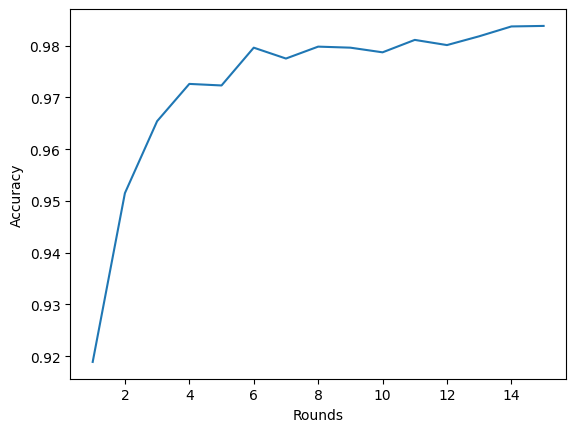

In [23]:
plt.plot(*zip(*history15.metrics_distributed['accuracy']))
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.show()

## Simulação com 20 rouds

In [24]:
history20 = fl.simulation.start_simulation(
    client_fn=client_fn_random,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=20),
    strategy=strategy,
)

INFO flwr 2023-04-17 19:38:51,268 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-04-17 19:38:55,944	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-17 19:38:56,792 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2574098841.0, 'GPU': 1.0, 'accelerator_type:G': 1.0, 'memory': 5148197684.0, 'node:192.168.15.122': 1.0, 'CPU': 8.0}
INFO flwr 2023-04-17 19:38:56,792 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-17 19:38:56,793 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-04-17 19:38:58,503 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-04-17 19:38:58,503 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-17 19:38:58,503 | server.py:101 | FL starting
DEBUG flwr 2023-04-17 19:38:58,504 | server.py:215 | fit_round 1: strategy s

(launch_and_fit pid=150023) 188/188 - 4s - loss: 0.5009 - accuracy: 0.8422 - 4s/epoch - 23ms/step
(launch_and_fit pid=150026) 188/188 - 6s - loss: 0.5109 - accuracy: 0.8398 - 6s/epoch - 33ms/step
(launch_and_fit pid=150025) 188/188 - 7s - loss: 0.4941 - accuracy: 0.8473 - 7s/epoch - 35ms/step
(launch_and_fit pid=150027) 188/188 - 6s - loss: 0.5128 - accuracy: 0.8382 - 6s/epoch - 34ms/step
(launch_and_fit pid=150022) 188/188 - 7s - loss: 0.5188 - accuracy: 0.8370 - 7s/epoch - 35ms/step
(launch_and_fit pid=150024) 188/188 - 6s - loss: 0.5145 - accuracy: 0.8413 - 6s/epoch - 34ms/step
(launch_and_fit pid=150021) 188/188 - 7s - loss: 0.5168 - accuracy: 0.8363 - 7s/epoch - 35ms/step
(launch_and_fit pid=150028) 188/188 - 7s - loss: 0.5000 - accuracy: 0.8440 - 7s/epoch - 35ms/step


DEBUG flwr 2023-04-17 19:39:09,166 | server.py:229 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-04-17 19:39:09,189 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-17 19:39:09,190 | server.py:165 | evaluate_round 1: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150023) 188/188 - 5s - loss: 0.4959 - accuracy: 0.8473 - 5s/epoch - 27ms/step
(launch_and_evaluate pid=150023) 32/32 - 1s - loss: 0.2293 - accuracy: 0.9320 - 600ms/epoch - 19ms/step
(launch_and_evaluate pid=150022) 32/32 - 1s - loss: 0.2409 - accuracy: 0.9270 - 548ms/epoch - 17ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.2583 - accuracy: 0.9230 - 566ms/epoch - 18ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.2460 - accuracy: 0.9280 - 553ms/epoch - 17ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.2560 - accuracy: 0.9310 - 547ms/epoch - 17ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.2322 - accuracy: 0.9330 - 576ms/epoch - 18ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.2271 - accuracy: 0.9430 - 545ms/epoch - 17ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.2404 - accuracy: 0.9310 - 571ms/epoch - 18ms/step


DEBUG flwr 2023-04-17 19:39:10,772 | server.py:179 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:39:10,772 | server.py:215 | fit_round 2: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150022) 32/32 - 0s - loss: 0.2287 - accuracy: 0.9380 - 223ms/epoch - 7ms/step
(launch_and_evaluate pid=150021) 32/32 - 0s - loss: 0.2350 - accuracy: 0.9410 - 226ms/epoch - 7ms/step
(launch_and_fit pid=150022) 188/188 - 6s - loss: 0.2561 - accuracy: 0.9223 - 6s/epoch - 34ms/step
(launch_and_fit pid=150023) 188/188 - 7s - loss: 0.2729 - accuracy: 0.9158 - 7s/epoch - 35ms/step
(launch_and_fit pid=150027) 188/188 - 7s - loss: 0.2566 - accuracy: 0.9227 - 7s/epoch - 35ms/step
(launch_and_fit pid=150021) 188/188 - 7s - loss: 0.2486 - accuracy: 0.9233 - 7s/epoch - 35ms/step
(launch_and_fit pid=150028) 188/188 - 7s - loss: 0.2491 - accuracy: 0.9207 - 7s/epoch - 35ms/step
(launch_and_fit pid=150025) 188/188 - 7s - loss: 0.2423 - accuracy: 0.9263 - 7s/epoch - 36ms/step
(launch_and_fit pid=150026) 188/188 - 7s - loss: 0.2491 - accuracy: 0.9242 - 7s/epoch - 36ms/step
(launch_and_fit pid=150024) 188/188 - 7s - loss: 0.2624 - accuracy: 0.9213 - 7s/epoch - 36ms/step


DEBUG flwr 2023-04-17 19:39:19,553 | server.py:229 | fit_round 2 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:39:19,569 | server.py:165 | evaluate_round 2: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150022) 188/188 - 1s - loss: 0.2382 - accuracy: 0.9290 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.1827 - accuracy: 0.9400 - 500ms/epoch - 16ms/step
(launch_and_evaluate pid=150026) 32/32 - 0s - loss: 0.1492 - accuracy: 0.9510 - 500ms/epoch - 16ms/step
(launch_and_evaluate pid=150023) 32/32 - 1s - loss: 0.1368 - accuracy: 0.9630 - 520ms/epoch - 16ms/step
(launch_and_evaluate pid=150022) 32/32 - 1s - loss: 0.1318 - accuracy: 0.9640 - 514ms/epoch - 16ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.1477 - accuracy: 0.9560 - 547ms/epoch - 17ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.1839 - accuracy: 0.9450 - 531ms/epoch - 17ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.1276 - accuracy: 0.9650 - 523ms/epoch - 16ms/step
(launch_and_evaluate pid=150021) 32/32 - 0s - loss: 0.1775 - accuracy: 0.9480 - 451ms/epoch - 14ms/step


DEBUG flwr 2023-04-17 19:39:21,158 | server.py:179 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:39:21,159 | server.py:215 | fit_round 3: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150025) 32/32 - 0s - loss: 0.1293 - accuracy: 0.9610 - 240ms/epoch - 7ms/step
(launch_and_evaluate pid=150026) 32/32 - 0s - loss: 0.1773 - accuracy: 0.9410 - 236ms/epoch - 7ms/step
(launch_and_fit pid=150025) 188/188 - 7s - loss: 0.1836 - accuracy: 0.9498 - 7s/epoch - 35ms/step
(launch_and_fit pid=150026) 188/188 - 7s - loss: 0.1714 - accuracy: 0.9525 - 7s/epoch - 36ms/step
(launch_and_fit pid=150024) 188/188 - 7s - loss: 0.1960 - accuracy: 0.9407 - 7s/epoch - 35ms/step
(launch_and_fit pid=150027) 188/188 - 7s - loss: 0.1850 - accuracy: 0.9465 - 7s/epoch - 36ms/step
(launch_and_fit pid=150023) 188/188 - 7s - loss: 0.1913 - accuracy: 0.9418 - 7s/epoch - 36ms/step
(launch_and_fit pid=150022) 188/188 - 7s - loss: 0.1943 - accuracy: 0.9408 - 7s/epoch - 36ms/step
(launch_and_fit pid=150021) 188/188 - 7s - loss: 0.1814 - accuracy: 0.9437 - 7s/epoch - 37ms/step
(launch_and_fit pid=150028) 188/188 - 7s - loss: 0.1804 - accuracy: 0.9458 - 7s/epoch - 37ms/step


DEBUG flwr 2023-04-17 19:39:30,520 | server.py:229 | fit_round 3 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:39:30,545 | server.py:165 | evaluate_round 3: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150025) 188/188 - 2s - loss: 0.1918 - accuracy: 0.9422 - 2s/epoch - 9ms/step
(launch_and_evaluate pid=150022) 32/32 - 1s - loss: 0.1161 - accuracy: 0.9630 - 743ms/epoch - 23ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.1185 - accuracy: 0.9720 - 696ms/epoch - 22ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.1322 - accuracy: 0.9570 - 686ms/epoch - 21ms/step
(launch_and_evaluate pid=150023) 32/32 - 1s - loss: 0.1107 - accuracy: 0.9640 - 774ms/epoch - 24ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.1353 - accuracy: 0.9560 - 730ms/epoch - 23ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.1195 - accuracy: 0.9650 - 776ms/epoch - 24ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.1072 - accuracy: 0.9680 - 850ms/epoch - 27ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.1029 - accuracy: 0.9720 - 811ms/epoch - 25ms/step


DEBUG flwr 2023-04-17 19:39:32,495 | server.py:179 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:39:32,496 | server.py:215 | fit_round 4: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150024) 32/32 - 0s - loss: 0.1242 - accuracy: 0.9660 - 231ms/epoch - 7ms/step
(launch_and_evaluate pid=150021) 32/32 - 0s - loss: 0.1247 - accuracy: 0.9610 - 226ms/epoch - 7ms/step
(launch_and_fit pid=150022) 188/188 - 6s - loss: 0.1467 - accuracy: 0.9548 - 6s/epoch - 34ms/step
(launch_and_fit pid=150021) 188/188 - 6s - loss: 0.1582 - accuracy: 0.9527 - 6s/epoch - 34ms/step
(launch_and_fit pid=150023) 188/188 - 6s - loss: 0.1497 - accuracy: 0.9540 - 6s/epoch - 34ms/step
(launch_and_fit pid=150025) 188/188 - 6s - loss: 0.1423 - accuracy: 0.9610 - 6s/epoch - 34ms/step
(launch_and_fit pid=150026) 188/188 - 6s - loss: 0.1426 - accuracy: 0.9568 - 6s/epoch - 34ms/step
(launch_and_fit pid=150027) 188/188 - 6s - loss: 0.1404 - accuracy: 0.9558 - 6s/epoch - 34ms/step
(launch_and_fit pid=150028) 188/188 - 6s - loss: 0.1516 - accuracy: 0.9550 - 6s/epoch - 34ms/step
(launch_and_fit pid=150024) 188/188 - 7s - loss: 0.1379 - accuracy: 0.9595 - 7s/epoch - 35ms/step


DEBUG flwr 2023-04-17 19:39:40,989 | server.py:229 | fit_round 4 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:39:41,014 | server.py:165 | evaluate_round 4: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150022) 188/188 - 1s - loss: 0.1455 - accuracy: 0.9538 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=150023) 32/32 - 0s - loss: 0.1031 - accuracy: 0.9770 - 496ms/epoch - 16ms/step
(launch_and_evaluate pid=150022) 32/32 - 1s - loss: 0.0951 - accuracy: 0.9680 - 551ms/epoch - 17ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.0914 - accuracy: 0.9750 - 510ms/epoch - 16ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.0914 - accuracy: 0.9680 - 537ms/epoch - 17ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.0869 - accuracy: 0.9740 - 536ms/epoch - 17ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.0838 - accuracy: 0.9770 - 566ms/epoch - 18ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.1021 - accuracy: 0.9740 - 525ms/epoch - 16ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.1020 - accuracy: 0.9670 - 518ms/epoch - 16ms/step


DEBUG flwr 2023-04-17 19:39:42,567 | server.py:179 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:39:42,567 | server.py:215 | fit_round 5: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150022) 32/32 - 0s - loss: 0.1164 - accuracy: 0.9610 - 216ms/epoch - 7ms/step
(launch_and_evaluate pid=150028) 32/32 - 0s - loss: 0.1010 - accuracy: 0.9710 - 219ms/epoch - 7ms/step
(launch_and_fit pid=150025) 188/188 - 7s - loss: 0.1396 - accuracy: 0.9580 - 7s/epoch - 37ms/step
(launch_and_fit pid=150023) 188/188 - 7s - loss: 0.1150 - accuracy: 0.9632 - 7s/epoch - 38ms/step
(launch_and_fit pid=150026) 188/188 - 7s - loss: 0.1100 - accuracy: 0.9687 - 7s/epoch - 38ms/step
(launch_and_fit pid=150024) 188/188 - 7s - loss: 0.1284 - accuracy: 0.9575 - 7s/epoch - 38ms/step
(launch_and_fit pid=150028) 188/188 - 7s - loss: 0.1153 - accuracy: 0.9650 - 7s/epoch - 38ms/step
(launch_and_fit pid=150022) 188/188 - 7s - loss: 0.1055 - accuracy: 0.9667 - 7s/epoch - 38ms/step
(launch_and_fit pid=150027) 188/188 - 7s - loss: 0.1314 - accuracy: 0.9613 - 7s/epoch - 39ms/step
(launch_and_fit pid=150021) 188/188 - 7s - loss: 0.1193 - accuracy: 0.9657 - 7s/epoch - 38ms/step


DEBUG flwr 2023-04-17 19:39:51,626 | server.py:229 | fit_round 5 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:39:51,645 | server.py:165 | evaluate_round 5: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150025) 188/188 - 1s - loss: 0.1334 - accuracy: 0.9600 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=150022) 32/32 - 1s - loss: 0.0817 - accuracy: 0.9770 - 616ms/epoch - 19ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.0902 - accuracy: 0.9750 - 615ms/epoch - 19ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.0932 - accuracy: 0.9750 - 670ms/epoch - 21ms/step
(launch_and_evaluate pid=150023) 32/32 - 1s - loss: 0.0853 - accuracy: 0.9800 - 753ms/epoch - 24ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.0972 - accuracy: 0.9650 - 681ms/epoch - 21ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.0716 - accuracy: 0.9740 - 809ms/epoch - 25ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.0881 - accuracy: 0.9740 - 790ms/epoch - 25ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.1034 - accuracy: 0.9680 - 739ms/epoch - 23ms/step


DEBUG flwr 2023-04-17 19:39:53,547 | server.py:179 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:39:53,548 | server.py:215 | fit_round 6: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150022) 32/32 - 0s - loss: 0.1055 - accuracy: 0.9640 - 229ms/epoch - 7ms/step
(launch_and_evaluate pid=150021) 32/32 - 0s - loss: 0.1043 - accuracy: 0.9680 - 231ms/epoch - 7ms/step
(launch_and_fit pid=150023) 188/188 - 7s - loss: 0.1144 - accuracy: 0.9682 - 7s/epoch - 36ms/step
(launch_and_fit pid=150022) 188/188 - 7s - loss: 0.0989 - accuracy: 0.9685 - 7s/epoch - 37ms/step
(launch_and_fit pid=150024) 188/188 - 7s - loss: 0.0988 - accuracy: 0.9715 - 7s/epoch - 36ms/step
(launch_and_fit pid=150028) 188/188 - 7s - loss: 0.1003 - accuracy: 0.9675 - 7s/epoch - 36ms/step
(launch_and_fit pid=150025) 188/188 - 7s - loss: 0.1000 - accuracy: 0.9715 - 7s/epoch - 37ms/step
(launch_and_fit pid=150026) 188/188 - 7s - loss: 0.1153 - accuracy: 0.9678 - 7s/epoch - 37ms/step
(launch_and_fit pid=150027) 188/188 - 7s - loss: 0.1086 - accuracy: 0.9685 - 7s/epoch - 37ms/step
(launch_and_fit pid=150021) 188/188 - 7s - loss: 0.1056 - accuracy: 0.9663 - 7s/epoch - 37ms/step


DEBUG flwr 2023-04-17 19:40:02,847 | server.py:229 | fit_round 6 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:40:02,866 | server.py:165 | evaluate_round 6: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150023) 188/188 - 1s - loss: 0.1049 - accuracy: 0.9690 - 1s/epoch - 8ms/step
(launch_and_evaluate pid=150022) 32/32 - 1s - loss: 0.0648 - accuracy: 0.9860 - 535ms/epoch - 17ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.0876 - accuracy: 0.9770 - 590ms/epoch - 18ms/step
(launch_and_evaluate pid=150023) 32/32 - 1s - loss: 0.0773 - accuracy: 0.9830 - 663ms/epoch - 21ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.0764 - accuracy: 0.9800 - 681ms/epoch - 21ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.0719 - accuracy: 0.9840 - 691ms/epoch - 22ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.0689 - accuracy: 0.9790 - 675ms/epoch - 21ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.0828 - accuracy: 0.9780 - 609ms/epoch - 19ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.0632 - accuracy: 0.9840 - 622ms/epoch - 19ms/step


DEBUG flwr 2023-04-17 19:40:04,574 | server.py:179 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:40:04,575 | server.py:215 | fit_round 7: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150022) 32/32 - 0s - loss: 0.0805 - accuracy: 0.9740 - 227ms/epoch - 7ms/step
(launch_and_evaluate pid=150026) 32/32 - 0s - loss: 0.0839 - accuracy: 0.9770 - 233ms/epoch - 7ms/step
(launch_and_fit pid=150023) 188/188 - 6s - loss: 0.0921 - accuracy: 0.9737 - 6s/epoch - 35ms/step
(launch_and_fit pid=150022) 188/188 - 7s - loss: 0.0914 - accuracy: 0.9722 - 7s/epoch - 35ms/step
(launch_and_fit pid=150027) 188/188 - 6s - loss: 0.0884 - accuracy: 0.9723 - 6s/epoch - 35ms/step
(launch_and_fit pid=150025) 188/188 - 7s - loss: 0.0968 - accuracy: 0.9705 - 7s/epoch - 36ms/step
(launch_and_fit pid=150026) 188/188 - 7s - loss: 0.0984 - accuracy: 0.9700 - 7s/epoch - 35ms/step
(launch_and_fit pid=150021) 188/188 - 7s - loss: 0.0838 - accuracy: 0.9762 - 7s/epoch - 35ms/step
(launch_and_fit pid=150028) 188/188 - 7s - loss: 0.1008 - accuracy: 0.9695 - 7s/epoch - 35ms/step
(launch_and_fit pid=150024) 188/188 - 7s - loss: 0.0930 - accuracy: 0.9725 - 7s/epoch - 36ms/step


DEBUG flwr 2023-04-17 19:40:13,240 | server.py:229 | fit_round 7 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:40:13,258 | server.py:165 | evaluate_round 7: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150023) 188/188 - 1s - loss: 0.0944 - accuracy: 0.9735 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=150023) 32/32 - 0s - loss: 0.0661 - accuracy: 0.9820 - 496ms/epoch - 16ms/step
(launch_and_evaluate pid=150022) 32/32 - 1s - loss: 0.0614 - accuracy: 0.9800 - 528ms/epoch - 16ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.0635 - accuracy: 0.9810 - 510ms/epoch - 16ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.0753 - accuracy: 0.9810 - 521ms/epoch - 16ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.0749 - accuracy: 0.9710 - 507ms/epoch - 16ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.0638 - accuracy: 0.9860 - 541ms/epoch - 17ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.0514 - accuracy: 0.9840 - 526ms/epoch - 16ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.0784 - accuracy: 0.9720 - 514ms/epoch - 16ms/step


DEBUG flwr 2023-04-17 19:40:14,840 | server.py:179 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:40:14,841 | server.py:215 | fit_round 8: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150023) 32/32 - 0s - loss: 0.0776 - accuracy: 0.9770 - 267ms/epoch - 8ms/step
(launch_and_evaluate pid=150025) 32/32 - 0s - loss: 0.0509 - accuracy: 0.9840 - 268ms/epoch - 8ms/step
(launch_and_fit pid=150023) 188/188 - 6s - loss: 0.0786 - accuracy: 0.9780 - 6s/epoch - 33ms/step
(launch_and_fit pid=150025) 188/188 - 6s - loss: 0.0761 - accuracy: 0.9763 - 6s/epoch - 33ms/step
(launch_and_fit pid=150026) 188/188 - 6s - loss: 0.0788 - accuracy: 0.9757 - 6s/epoch - 33ms/step
(launch_and_fit pid=150021) 188/188 - 6s - loss: 0.0763 - accuracy: 0.9755 - 6s/epoch - 33ms/step
(launch_and_fit pid=150028) 188/188 - 6s - loss: 0.0790 - accuracy: 0.9760 - 6s/epoch - 34ms/step
(launch_and_fit pid=150027) 188/188 - 6s - loss: 0.0912 - accuracy: 0.9705 - 6s/epoch - 34ms/step
(launch_and_fit pid=150024) 188/188 - 6s - loss: 0.0790 - accuracy: 0.9757 - 6s/epoch - 34ms/step
(launch_and_fit pid=150022) 188/188 - 7s - loss: 0.0801 - accuracy: 0.9747 - 7s/epoch - 35ms/step


DEBUG flwr 2023-04-17 19:40:23,075 | server.py:229 | fit_round 8 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:40:23,090 | server.py:165 | evaluate_round 8: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150023) 188/188 - 1s - loss: 0.0869 - accuracy: 0.9768 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=150022) 32/32 - 1s - loss: 0.0776 - accuracy: 0.9760 - 576ms/epoch - 18ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.0780 - accuracy: 0.9800 - 536ms/epoch - 17ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.0581 - accuracy: 0.9850 - 538ms/epoch - 17ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.0845 - accuracy: 0.9720 - 550ms/epoch - 17ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.0663 - accuracy: 0.9750 - 561ms/epoch - 18ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.0678 - accuracy: 0.9820 - 512ms/epoch - 16ms/step
(launch_and_evaluate pid=150023) 32/32 - 1s - loss: 0.0585 - accuracy: 0.9790 - 587ms/epoch - 18ms/step
(launch_and_evaluate pid=150025) 32/32 - 0s - loss: 0.0807 - accuracy: 0.9750 - 399ms/epoch - 12ms/step


DEBUG flwr 2023-04-17 19:40:24,641 | server.py:179 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:40:24,641 | server.py:215 | fit_round 9: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150027) 32/32 - 0s - loss: 0.0706 - accuracy: 0.9790 - 215ms/epoch - 7ms/step
(launch_and_evaluate pid=150028) 32/32 - 0s - loss: 0.0679 - accuracy: 0.9790 - 217ms/epoch - 7ms/step
(launch_and_fit pid=150026) 188/188 - 6s - loss: 0.0643 - accuracy: 0.9802 - 6s/epoch - 33ms/step
(launch_and_fit pid=150025) 188/188 - 6s - loss: 0.0829 - accuracy: 0.9745 - 6s/epoch - 34ms/step
(launch_and_fit pid=150027) 188/188 - 6s - loss: 0.0771 - accuracy: 0.9770 - 6s/epoch - 34ms/step
(launch_and_fit pid=150021) 188/188 - 6s - loss: 0.0754 - accuracy: 0.9788 - 6s/epoch - 33ms/step
(launch_and_fit pid=150028) 188/188 - 6s - loss: 0.0753 - accuracy: 0.9785 - 6s/epoch - 34ms/step
(launch_and_fit pid=150022) 188/188 - 6s - loss: 0.0876 - accuracy: 0.9727 - 6s/epoch - 34ms/step
(launch_and_fit pid=150024) 188/188 - 6s - loss: 0.0830 - accuracy: 0.9758 - 6s/epoch - 34ms/step
(launch_and_fit pid=150023) 188/188 - 6s - loss: 0.0816 - accuracy: 0.9753 - 6s/epoch - 33ms/step


DEBUG flwr 2023-04-17 19:40:33,053 | server.py:229 | fit_round 9 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:40:33,069 | server.py:165 | evaluate_round 9: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150026) 188/188 - 1s - loss: 0.0759 - accuracy: 0.9765 - 1s/epoch - 7ms/step
(launch_and_evaluate pid=150023) 32/32 - 1s - loss: 0.0515 - accuracy: 0.9830 - 512ms/epoch - 16ms/step
(launch_and_evaluate pid=150022) 32/32 - 1s - loss: 0.0646 - accuracy: 0.9810 - 520ms/epoch - 16ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.0657 - accuracy: 0.9770 - 526ms/epoch - 16ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.0715 - accuracy: 0.9790 - 511ms/epoch - 16ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.0592 - accuracy: 0.9830 - 506ms/epoch - 16ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.0686 - accuracy: 0.9810 - 542ms/epoch - 17ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.0536 - accuracy: 0.9840 - 530ms/epoch - 17ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.0747 - accuracy: 0.9770 - 649ms/epoch - 20ms/step


DEBUG flwr 2023-04-17 19:40:34,586 | server.py:179 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:40:34,586 | server.py:215 | fit_round 10: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150022) 32/32 - 0s - loss: 0.0657 - accuracy: 0.9800 - 219ms/epoch - 7ms/step
(launch_and_evaluate pid=150026) 32/32 - 0s - loss: 0.0560 - accuracy: 0.9830 - 222ms/epoch - 7ms/step
(launch_and_fit pid=150024) 188/188 - 6s - loss: 0.0687 - accuracy: 0.9820 - 6s/epoch - 33ms/step
(launch_and_fit pid=150023) 188/188 - 6s - loss: 0.0662 - accuracy: 0.9798 - 6s/epoch - 33ms/step
(launch_and_fit pid=150025) 188/188 - 6s - loss: 0.0713 - accuracy: 0.9790 - 6s/epoch - 33ms/step
(launch_and_fit pid=150026) 188/188 - 6s - loss: 0.0702 - accuracy: 0.9807 - 6s/epoch - 33ms/step
(launch_and_fit pid=150021) 188/188 - 6s - loss: 0.0621 - accuracy: 0.9842 - 6s/epoch - 33ms/step
(launch_and_fit pid=150022) 188/188 - 6s - loss: 0.0722 - accuracy: 0.9775 - 6s/epoch - 34ms/step
(launch_and_fit pid=150028) 188/188 - 6s - loss: 0.0678 - accuracy: 0.9792 - 6s/epoch - 34ms/step
(launch_and_fit pid=150027) 188/188 - 6s - loss: 0.0673 - accuracy: 0.9777 - 6s/epoch - 34ms/step


DEBUG flwr 2023-04-17 19:40:42,868 | server.py:229 | fit_round 10 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:40:42,885 | server.py:165 | evaluate_round 10: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150025) 188/188 - 1s - loss: 0.0661 - accuracy: 0.9815 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=150022) 32/32 - 1s - loss: 0.0446 - accuracy: 0.9870 - 509ms/epoch - 16ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.0365 - accuracy: 0.9920 - 511ms/epoch - 16ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.0505 - accuracy: 0.9820 - 523ms/epoch - 16ms/step
(launch_and_evaluate pid=150023) 32/32 - 1s - loss: 0.0567 - accuracy: 0.9810 - 530ms/epoch - 17ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.0615 - accuracy: 0.9810 - 525ms/epoch - 16ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.0711 - accuracy: 0.9750 - 520ms/epoch - 16ms/step
(launch_and_evaluate pid=150021) 32/32 - 0s - loss: 0.0462 - accuracy: 0.9880 - 404ms/epoch - 13ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.0529 - accuracy: 0.9840 - 671ms/epoch - 21ms/step


DEBUG flwr 2023-04-17 19:40:44,414 | server.py:179 | evaluate_round 10 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:40:44,415 | server.py:215 | fit_round 11: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150025) 32/32 - 0s - loss: 0.0578 - accuracy: 0.9830 - 216ms/epoch - 7ms/step
(launch_and_evaluate pid=150022) 32/32 - 0s - loss: 0.0515 - accuracy: 0.9800 - 218ms/epoch - 7ms/step
(launch_and_fit pid=150023) 188/188 - 6s - loss: 0.0528 - accuracy: 0.9852 - 6s/epoch - 34ms/step
(launch_and_fit pid=150022) 188/188 - 6s - loss: 0.0496 - accuracy: 0.9840 - 6s/epoch - 34ms/step
(launch_and_fit pid=150025) 188/188 - 6s - loss: 0.0663 - accuracy: 0.9797 - 6s/epoch - 33ms/step
(launch_and_fit pid=150028) 188/188 - 6s - loss: 0.0631 - accuracy: 0.9818 - 6s/epoch - 33ms/step
(launch_and_fit pid=150026) 188/188 - 6s - loss: 0.0661 - accuracy: 0.9802 - 6s/epoch - 34ms/step
(launch_and_fit pid=150027) 188/188 - 6s - loss: 0.0515 - accuracy: 0.9843 - 6s/epoch - 34ms/step
(launch_and_fit pid=150024) 188/188 - 6s - loss: 0.0715 - accuracy: 0.9768 - 6s/epoch - 34ms/step
(launch_and_fit pid=150021) 188/188 - 6s - loss: 0.0631 - accuracy: 0.9818 - 6s/epoch - 34ms/step


DEBUG flwr 2023-04-17 19:40:52,816 | server.py:229 | fit_round 11 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:40:52,832 | server.py:165 | evaluate_round 11: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150028) 188/188 - 1s - loss: 0.0579 - accuracy: 0.9848 - 1s/epoch - 7ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.0604 - accuracy: 0.9800 - 518ms/epoch - 16ms/step
(launch_and_evaluate pid=150023) 32/32 - 1s - loss: 0.0431 - accuracy: 0.9890 - 558ms/epoch - 17ms/step
(launch_and_evaluate pid=150022) 32/32 - 1s - loss: 0.0454 - accuracy: 0.9870 - 552ms/epoch - 17ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.0375 - accuracy: 0.9880 - 576ms/epoch - 18ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.0368 - accuracy: 0.9900 - 629ms/epoch - 20ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.0564 - accuracy: 0.9850 - 612ms/epoch - 19ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.0543 - accuracy: 0.9790 - 610ms/epoch - 19ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.0550 - accuracy: 0.9830 - 619ms/epoch - 19ms/step


DEBUG flwr 2023-04-17 19:40:54,398 | server.py:179 | evaluate_round 11 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:40:54,399 | server.py:215 | fit_round 12: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150022) 32/32 - 0s - loss: 0.0367 - accuracy: 0.9890 - 222ms/epoch - 7ms/step
(launch_and_evaluate pid=150028) 32/32 - 0s - loss: 0.0573 - accuracy: 0.9820 - 213ms/epoch - 7ms/step
(launch_and_fit pid=150028) 188/188 - 7s - loss: 0.0628 - accuracy: 0.9820 - 7s/epoch - 36ms/step
(launch_and_fit pid=150021) 188/188 - 7s - loss: 0.0569 - accuracy: 0.9840 - 7s/epoch - 37ms/step
(launch_and_fit pid=150022) 188/188 - 7s - loss: 0.0661 - accuracy: 0.9798 - 7s/epoch - 37ms/step
(launch_and_fit pid=150025) 188/188 - 7s - loss: 0.0646 - accuracy: 0.9817 - 7s/epoch - 37ms/step
(launch_and_fit pid=150023) 188/188 - 7s - loss: 0.0606 - accuracy: 0.9815 - 7s/epoch - 37ms/step
(launch_and_fit pid=150026) 188/188 - 7s - loss: 0.0568 - accuracy: 0.9843 - 7s/epoch - 38ms/step
(launch_and_fit pid=150027) 188/188 - 7s - loss: 0.0625 - accuracy: 0.9808 - 7s/epoch - 37ms/step
(launch_and_fit pid=150024) 188/188 - 7s - loss: 0.0617 - accuracy: 0.9828 - 7s/epoch - 37ms/step


DEBUG flwr 2023-04-17 19:41:03,395 | server.py:229 | fit_round 12 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:41:03,411 | server.py:165 | evaluate_round 12: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150028) 188/188 - 1s - loss: 0.0679 - accuracy: 0.9792 - 1s/epoch - 7ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.0481 - accuracy: 0.9870 - 570ms/epoch - 18ms/step
(launch_and_evaluate pid=150023) 32/32 - 1s - loss: 0.0493 - accuracy: 0.9830 - 606ms/epoch - 19ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.0513 - accuracy: 0.9810 - 587ms/epoch - 18ms/step
(launch_and_evaluate pid=150022) 32/32 - 1s - loss: 0.0384 - accuracy: 0.9870 - 536ms/epoch - 17ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.0419 - accuracy: 0.9870 - 595ms/epoch - 19ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.0567 - accuracy: 0.9850 - 540ms/epoch - 17ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.0551 - accuracy: 0.9820 - 541ms/epoch - 17ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.0503 - accuracy: 0.9870 - 604ms/epoch - 19ms/step


DEBUG flwr 2023-04-17 19:41:05,072 | server.py:179 | evaluate_round 12 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:41:05,072 | server.py:215 | fit_round 13: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150023) 32/32 - 0s - loss: 0.0460 - accuracy: 0.9820 - 220ms/epoch - 7ms/step
(launch_and_evaluate pid=150024) 32/32 - 0s - loss: 0.0532 - accuracy: 0.9850 - 226ms/epoch - 7ms/step
(launch_and_fit pid=150027) 188/188 - 7s - loss: 0.0563 - accuracy: 0.9803 - 7s/epoch - 35ms/step
(launch_and_fit pid=150025) 188/188 - 7s - loss: 0.0490 - accuracy: 0.9860 - 7s/epoch - 36ms/step
(launch_and_fit pid=150023) 188/188 - 7s - loss: 0.0548 - accuracy: 0.9830 - 7s/epoch - 36ms/step
(launch_and_fit pid=150026) 188/188 - 7s - loss: 0.0542 - accuracy: 0.9855 - 7s/epoch - 36ms/step
(launch_and_fit pid=150022) 188/188 - 7s - loss: 0.0576 - accuracy: 0.9820 - 7s/epoch - 37ms/step
(launch_and_fit pid=150024) 188/188 - 7s - loss: 0.0548 - accuracy: 0.9842 - 7s/epoch - 37ms/step
(launch_and_fit pid=150021) 188/188 - 7s - loss: 0.0527 - accuracy: 0.9845 - 7s/epoch - 37ms/step
(launch_and_fit pid=150028) 188/188 - 7s - loss: 0.0583 - accuracy: 0.9833 - 7s/epoch - 37ms/step


DEBUG flwr 2023-04-17 19:41:13,961 | server.py:229 | fit_round 13 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:41:13,977 | server.py:165 | evaluate_round 13: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150027) 188/188 - 1s - loss: 0.0492 - accuracy: 0.9857 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=150022) 32/32 - 1s - loss: 0.0613 - accuracy: 0.9770 - 516ms/epoch - 16ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.0586 - accuracy: 0.9830 - 527ms/epoch - 16ms/step
(launch_and_evaluate pid=150027) 32/32 - 0s - loss: 0.0405 - accuracy: 0.9850 - 467ms/epoch - 15ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.0482 - accuracy: 0.9820 - 531ms/epoch - 17ms/step
(launch_and_evaluate pid=150023) 32/32 - 1s - loss: 0.0416 - accuracy: 0.9840 - 528ms/epoch - 16ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.0392 - accuracy: 0.9870 - 513ms/epoch - 16ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.0441 - accuracy: 0.9830 - 531ms/epoch - 17ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.0483 - accuracy: 0.9790 - 543ms/epoch - 17ms/step


DEBUG flwr 2023-04-17 19:41:15,461 | server.py:179 | evaluate_round 13 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:41:15,461 | server.py:215 | fit_round 14: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150022) 32/32 - 0s - loss: 0.0378 - accuracy: 0.9880 - 211ms/epoch - 7ms/step
(launch_and_evaluate pid=150027) 32/32 - 0s - loss: 0.0401 - accuracy: 0.9820 - 204ms/epoch - 6ms/step
(launch_and_fit pid=150022) 188/188 - 7s - loss: 0.0534 - accuracy: 0.9848 - 7s/epoch - 37ms/step
(launch_and_fit pid=150025) 188/188 - 7s - loss: 0.0592 - accuracy: 0.9813 - 7s/epoch - 37ms/step
(launch_and_fit pid=150027) 188/188 - 7s - loss: 0.0431 - accuracy: 0.9885 - 7s/epoch - 37ms/step
(launch_and_fit pid=150028) 188/188 - 7s - loss: 0.0535 - accuracy: 0.9842 - 7s/epoch - 37ms/step
(launch_and_fit pid=150021) 188/188 - 7s - loss: 0.0542 - accuracy: 0.9852 - 7s/epoch - 37ms/step
(launch_and_fit pid=150023) 188/188 - 7s - loss: 0.0519 - accuracy: 0.9848 - 7s/epoch - 38ms/step
(launch_and_fit pid=150026) 188/188 - 7s - loss: 0.0575 - accuracy: 0.9835 - 7s/epoch - 38ms/step
(launch_and_fit pid=150024) 188/188 - 7s - loss: 0.0599 - accuracy: 0.9813 - 7s/epoch - 38ms/step


DEBUG flwr 2023-04-17 19:41:24,665 | server.py:229 | fit_round 14 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:41:24,684 | server.py:165 | evaluate_round 14: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150022) 188/188 - 1s - loss: 0.0503 - accuracy: 0.9853 - 1s/epoch - 7ms/step
(launch_and_evaluate pid=150023) 32/32 - 1s - loss: 0.0340 - accuracy: 0.9850 - 500ms/epoch - 16ms/step
(launch_and_evaluate pid=150022) 32/32 - 1s - loss: 0.0555 - accuracy: 0.9840 - 504ms/epoch - 16ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.0435 - accuracy: 0.9850 - 520ms/epoch - 16ms/step
(launch_and_evaluate pid=150027) 32/32 - 0s - loss: 0.0650 - accuracy: 0.9770 - 500ms/epoch - 16ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.0397 - accuracy: 0.9850 - 529ms/epoch - 17ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.0388 - accuracy: 0.9860 - 528ms/epoch - 17ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.0605 - accuracy: 0.9850 - 535ms/epoch - 17ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.0583 - accuracy: 0.9870 - 534ms/epoch - 17ms/step


DEBUG flwr 2023-04-17 19:41:26,419 | server.py:179 | evaluate_round 14 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:41:26,419 | server.py:215 | fit_round 15: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150023) 32/32 - 0s - loss: 0.0514 - accuracy: 0.9820 - 213ms/epoch - 7ms/step
(launch_and_evaluate pid=150022) 32/32 - 0s - loss: 0.0361 - accuracy: 0.9890 - 217ms/epoch - 7ms/step
(launch_and_fit pid=150028) 188/188 - 6s - loss: 0.0489 - accuracy: 0.9882 - 6s/epoch - 34ms/step
(launch_and_fit pid=150026) 188/188 - 7s - loss: 0.0379 - accuracy: 0.9897 - 7s/epoch - 35ms/step
(launch_and_fit pid=150023) 188/188 - 7s - loss: 0.0493 - accuracy: 0.9853 - 7s/epoch - 35ms/step
(launch_and_fit pid=150025) 188/188 - 7s - loss: 0.0373 - accuracy: 0.9882 - 7s/epoch - 35ms/step
(launch_and_fit pid=150027) 188/188 - 7s - loss: 0.0453 - accuracy: 0.9893 - 7s/epoch - 36ms/step
(launch_and_fit pid=150024) 188/188 - 7s - loss: 0.0527 - accuracy: 0.9828 - 7s/epoch - 36ms/step
(launch_and_fit pid=150022) 188/188 - 6s - loss: 0.0435 - accuracy: 0.9868 - 6s/epoch - 33ms/step
(launch_and_fit pid=150021) 188/188 - 7s - loss: 0.0469 - accuracy: 0.9868 - 7s/epoch - 35ms/step


DEBUG flwr 2023-04-17 19:41:35,073 | server.py:229 | fit_round 15 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:41:35,091 | server.py:165 | evaluate_round 15: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150028) 188/188 - 1s - loss: 0.0458 - accuracy: 0.9852 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=150022) 32/32 - 1s - loss: 0.0521 - accuracy: 0.9800 - 522ms/epoch - 16ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.0295 - accuracy: 0.9900 - 506ms/epoch - 16ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.0446 - accuracy: 0.9840 - 508ms/epoch - 16ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.0492 - accuracy: 0.9830 - 513ms/epoch - 16ms/step
(launch_and_evaluate pid=150023) 32/32 - 1s - loss: 0.0408 - accuracy: 0.9890 - 549ms/epoch - 17ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.0467 - accuracy: 0.9830 - 508ms/epoch - 16ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.0627 - accuracy: 0.9810 - 518ms/epoch - 16ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.0496 - accuracy: 0.9820 - 545ms/epoch - 17ms/step


DEBUG flwr 2023-04-17 19:41:36,825 | server.py:179 | evaluate_round 15 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:41:36,825 | server.py:215 | fit_round 16: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150022) 32/32 - 0s - loss: 0.0536 - accuracy: 0.9810 - 211ms/epoch - 7ms/step
(launch_and_evaluate pid=150028) 32/32 - 0s - loss: 0.0433 - accuracy: 0.9840 - 223ms/epoch - 7ms/step
(launch_and_fit pid=150026) 188/188 - 6s - loss: 0.0500 - accuracy: 0.9845 - 6s/epoch - 33ms/step
(launch_and_fit pid=150022) 188/188 - 6s - loss: 0.0396 - accuracy: 0.9883 - 6s/epoch - 33ms/step
(launch_and_fit pid=150027) 188/188 - 6s - loss: 0.0440 - accuracy: 0.9862 - 6s/epoch - 34ms/step
(launch_and_fit pid=150024) 188/188 - 6s - loss: 0.0452 - accuracy: 0.9873 - 6s/epoch - 34ms/step
(launch_and_fit pid=150023) 188/188 - 6s - loss: 0.0427 - accuracy: 0.9890 - 6s/epoch - 34ms/step
(launch_and_fit pid=150021) 188/188 - 6s - loss: 0.0501 - accuracy: 0.9850 - 6s/epoch - 34ms/step
(launch_and_fit pid=150028) 188/188 - 6s - loss: 0.0485 - accuracy: 0.9873 - 6s/epoch - 34ms/step
(launch_and_fit pid=150025) 188/188 - 7s - loss: 0.0464 - accuracy: 0.9855 - 7s/epoch - 35ms/step


DEBUG flwr 2023-04-17 19:41:45,161 | server.py:229 | fit_round 16 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:41:45,177 | server.py:165 | evaluate_round 16: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150026) 188/188 - 1s - loss: 0.0377 - accuracy: 0.9890 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.0521 - accuracy: 0.9790 - 587ms/epoch - 18ms/step
(launch_and_evaluate pid=150023) 32/32 - 1s - loss: 0.0305 - accuracy: 0.9890 - 534ms/epoch - 17ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.0591 - accuracy: 0.9800 - 525ms/epoch - 16ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.0541 - accuracy: 0.9850 - 617ms/epoch - 19ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.0451 - accuracy: 0.9840 - 569ms/epoch - 18ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.0518 - accuracy: 0.9820 - 559ms/epoch - 17ms/step
(launch_and_evaluate pid=150028) 32/32 - 0s - loss: 0.0566 - accuracy: 0.9810 - 417ms/epoch - 13ms/step
(launch_and_evaluate pid=150025) 32/32 - 0s - loss: 0.0404 - accuracy: 0.9880 - 209ms/epoch - 7ms/step
(launch_and_evaluate pid=150025) 32/32 - 0s - loss: 0.0318 - accuracy: 0

DEBUG flwr 2023-04-17 19:41:49,162 | server.py:179 | evaluate_round 16 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:41:49,162 | server.py:215 | fit_round 17: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=154777) 32/32 - 0s - loss: 0.0509 - accuracy: 0.9800 - 236ms/epoch - 7ms/step


(raylet) [2023-04-17 19:41:55,925 E 149933 149933] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: cdd04d29548b00fe5e8cdeccb34c9d90c498403e689a9dadec8334b9, IP: 192.168.15.122) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.15.122`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_fit pid=150027) 188/188 - 6s - loss: 0.0417 - accuracy: 0.9877 - 6s/epoch - 34ms/step
(launch_and_fit pid=154777) 188/188 - 6s - loss: 0.0448 - accuracy: 0.9870 - 6s/epoch - 34ms/step
(launch_and_fit pid=150025) 188/188 - 7s - loss: 0.0422 - accuracy: 0.9870 - 7s/epoch - 35ms/step
(launch_and_fit pid=150021) 188/188 - 7s - loss: 0.0449 - accuracy: 0.9855 - 7s/epoch - 35ms/step
(launch_and_fit pid=150024) 188/188 - 7s - loss: 0.0411 - accuracy: 0.9865 - 7s/epoch - 35ms/step
(launch_and_fit pid=150026) 188/188 - 7s - loss: 0.0468 - accuracy: 0.9863 - 7s/epoch - 36ms/step
(launch_and_fit pid=150028) 188/188 - 7s - loss: 0.0421 - accuracy: 0.9870 - 7s/epoch - 36ms/step
(launch_and_fit pid=150023) 188/188 - 7s - loss: 0.0468 - accuracy: 0.9852 - 7s/epoch - 37ms/step


DEBUG flwr 2023-04-17 19:41:57,845 | server.py:229 | fit_round 17 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:41:57,861 | server.py:165 | evaluate_round 17: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150027) 188/188 - 1s - loss: 0.0511 - accuracy: 0.9865 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=150023) 32/32 - 1s - loss: 0.0323 - accuracy: 0.9890 - 544ms/epoch - 17ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.0502 - accuracy: 0.9830 - 506ms/epoch - 16ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.0500 - accuracy: 0.9820 - 524ms/epoch - 16ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.0539 - accuracy: 0.9840 - 530ms/epoch - 17ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.0458 - accuracy: 0.9780 - 511ms/epoch - 16ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.0446 - accuracy: 0.9820 - 536ms/epoch - 17ms/step
(launch_and_evaluate pid=154777) 32/32 - 1s - loss: 0.0345 - accuracy: 0.9890 - 526ms/epoch - 16ms/step
(launch_and_evaluate pid=150026) 32/32 - 0s - loss: 0.0403 - accuracy: 0.9870 - 373ms/epoch - 12ms/step


DEBUG flwr 2023-04-17 19:41:59,536 | server.py:179 | evaluate_round 17 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:41:59,537 | server.py:215 | fit_round 18: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150021) 32/32 - 0s - loss: 0.0466 - accuracy: 0.9820 - 204ms/epoch - 6ms/step
(launch_and_evaluate pid=150027) 32/32 - 0s - loss: 0.0428 - accuracy: 0.9870 - 216ms/epoch - 7ms/step
(launch_and_fit pid=150027) 188/188 - 6s - loss: 0.0351 - accuracy: 0.9897 - 6s/epoch - 34ms/step
(launch_and_fit pid=150021) 188/188 - 6s - loss: 0.0440 - accuracy: 0.9868 - 6s/epoch - 34ms/step
(launch_and_fit pid=150025) 188/188 - 6s - loss: 0.0444 - accuracy: 0.9872 - 6s/epoch - 34ms/step
(launch_and_fit pid=150026) 188/188 - 6s - loss: 0.0357 - accuracy: 0.9908 - 6s/epoch - 34ms/step
(launch_and_fit pid=150023) 188/188 - 7s - loss: 0.0413 - accuracy: 0.9875 - 7s/epoch - 35ms/step
(launch_and_fit pid=150024) 188/188 - 7s - loss: 0.0459 - accuracy: 0.9848 - 7s/epoch - 35ms/step
(launch_and_fit pid=150028) 188/188 - 7s - loss: 0.0380 - accuracy: 0.9883 - 7s/epoch - 35ms/step
(launch_and_fit pid=154777) 188/188 - 7s - loss: 0.0361 - accuracy: 0.9887 - 7s/epoch - 35ms/step


DEBUG flwr 2023-04-17 19:42:08,169 | server.py:229 | fit_round 18 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:42:08,187 | server.py:165 | evaluate_round 18: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150021) 188/188 - 1s - loss: 0.0392 - accuracy: 0.9880 - 1s/epoch - 7ms/step
(launch_and_evaluate pid=150023) 32/32 - 1s - loss: 0.0314 - accuracy: 0.9880 - 548ms/epoch - 17ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.0477 - accuracy: 0.9850 - 546ms/epoch - 17ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.0413 - accuracy: 0.9850 - 536ms/epoch - 17ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.0426 - accuracy: 0.9880 - 563ms/epoch - 18ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.0519 - accuracy: 0.9810 - 535ms/epoch - 17ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.0619 - accuracy: 0.9760 - 551ms/epoch - 17ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.0323 - accuracy: 0.9890 - 562ms/epoch - 18ms/step
(launch_and_evaluate pid=154777) 32/32 - 1s - loss: 0.0348 - accuracy: 0.9860 - 519ms/epoch - 16ms/step


DEBUG flwr 2023-04-17 19:42:09,778 | server.py:179 | evaluate_round 18 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:42:09,779 | server.py:215 | fit_round 19: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150023) 32/32 - 0s - loss: 0.0346 - accuracy: 0.9880 - 238ms/epoch - 7ms/step
(launch_and_evaluate pid=150021) 32/32 - 0s - loss: 0.0382 - accuracy: 0.9900 - 226ms/epoch - 7ms/step
(launch_and_fit pid=150025) 188/188 - 6s - loss: 0.0371 - accuracy: 0.9915 - 6s/epoch - 34ms/step
(launch_and_fit pid=150027) 188/188 - 6s - loss: 0.0369 - accuracy: 0.9902 - 6s/epoch - 35ms/step
(launch_and_fit pid=150021) 188/188 - 6s - loss: 0.0362 - accuracy: 0.9883 - 6s/epoch - 34ms/step
(launch_and_fit pid=154777) 188/188 - 7s - loss: 0.0403 - accuracy: 0.9878 - 7s/epoch - 35ms/step
(launch_and_fit pid=150023) 188/188 - 7s - loss: 0.0427 - accuracy: 0.9873 - 7s/epoch - 36ms/step
(launch_and_fit pid=150026) 188/188 - 7s - loss: 0.0405 - accuracy: 0.9863 - 7s/epoch - 35ms/step
(launch_and_fit pid=150024) 188/188 - 7s - loss: 0.0324 - accuracy: 0.9902 - 7s/epoch - 35ms/step
(launch_and_fit pid=150028) 188/188 - 7s - loss: 0.0371 - accuracy: 0.9898 - 7s/epoch - 35ms/step


DEBUG flwr 2023-04-17 19:42:18,252 | server.py:229 | fit_round 19 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:42:18,268 | server.py:165 | evaluate_round 19: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=150025) 188/188 - 1s - loss: 0.0368 - accuracy: 0.9890 - 1s/epoch - 6ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.0382 - accuracy: 0.9850 - 511ms/epoch - 16ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.0326 - accuracy: 0.9880 - 525ms/epoch - 16ms/step
(launch_and_evaluate pid=154777) 32/32 - 1s - loss: 0.0355 - accuracy: 0.9860 - 524ms/epoch - 16ms/step
(launch_and_evaluate pid=150023) 32/32 - 1s - loss: 0.0390 - accuracy: 0.9890 - 593ms/epoch - 19ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.0453 - accuracy: 0.9830 - 572ms/epoch - 18ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.0358 - accuracy: 0.9860 - 529ms/epoch - 17ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.0358 - accuracy: 0.9860 - 559ms/epoch - 17ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.0283 - accuracy: 0.9920 - 682ms/epoch - 21ms/step


DEBUG flwr 2023-04-17 19:42:19,829 | server.py:179 | evaluate_round 19 received 10 results and 0 failures
DEBUG flwr 2023-04-17 19:42:19,830 | server.py:215 | fit_round 20: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=150025) 32/32 - 0s - loss: 0.0407 - accuracy: 0.9850 - 220ms/epoch - 7ms/step
(launch_and_evaluate pid=154777) 32/32 - 0s - loss: 0.0404 - accuracy: 0.9890 - 224ms/epoch - 7ms/step
(launch_and_fit pid=150025) 188/188 - 7s - loss: 0.0380 - accuracy: 0.9897 - 7s/epoch - 40ms/step
(launch_and_fit pid=154777) 188/188 - 7s - loss: 0.0336 - accuracy: 0.9900 - 7s/epoch - 39ms/step
(launch_and_fit pid=150021) 188/188 - 8s - loss: 0.0377 - accuracy: 0.9885 - 8s/epoch - 40ms/step
(launch_and_fit pid=150027) 188/188 - 8s - loss: 0.0427 - accuracy: 0.9863 - 8s/epoch - 41ms/step
(launch_and_fit pid=150026) 188/188 - 8s - loss: 0.0402 - accuracy: 0.9875 - 8s/epoch - 41ms/step
(launch_and_fit pid=150024) 188/188 - 8s - loss: 0.0297 - accuracy: 0.9903 - 8s/epoch - 41ms/step
(launch_and_fit pid=150028) 188/188 - 8s - loss: 0.0377 - accuracy: 0.9888 - 8s/epoch - 41ms/step
(launch_and_fit pid=150023) 188/188 - 8s - loss: 0.0402 - accuracy: 0.9890 - 8s/epoch - 42ms/step


DEBUG flwr 2023-04-17 19:42:29,902 | server.py:229 | fit_round 20 received 9 results and 0 failures
DEBUG flwr 2023-04-17 19:42:29,937 | server.py:165 | evaluate_round 20: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=154777) 188/188 - 2s - loss: 0.0387 - accuracy: 0.9880 - 2s/epoch - 8ms/step
(launch_and_evaluate pid=150023) 32/32 - 0s - loss: 0.0364 - accuracy: 0.9880 - 487ms/epoch - 15ms/step
(launch_and_evaluate pid=154777) 32/32 - 1s - loss: 0.0284 - accuracy: 0.9890 - 509ms/epoch - 16ms/step
(launch_and_evaluate pid=150025) 32/32 - 1s - loss: 0.0297 - accuracy: 0.9890 - 510ms/epoch - 16ms/step
(launch_and_evaluate pid=150026) 32/32 - 1s - loss: 0.0369 - accuracy: 0.9870 - 531ms/epoch - 17ms/step
(launch_and_evaluate pid=150027) 32/32 - 1s - loss: 0.0507 - accuracy: 0.9810 - 577ms/epoch - 18ms/step
(launch_and_evaluate pid=150024) 32/32 - 1s - loss: 0.0448 - accuracy: 0.9840 - 607ms/epoch - 19ms/step
(launch_and_evaluate pid=150021) 32/32 - 1s - loss: 0.0494 - accuracy: 0.9810 - 585ms/epoch - 18ms/step
(launch_and_evaluate pid=150028) 32/32 - 1s - loss: 0.0412 - accuracy: 0.9870 - 617ms/epoch - 19ms/step


DEBUG flwr 2023-04-17 19:42:31,658 | server.py:179 | evaluate_round 20 received 10 results and 0 failures
INFO flwr 2023-04-17 19:42:31,658 | server.py:144 | FL finished in 213.15404935600236
INFO flwr 2023-04-17 19:42:31,659 | app.py:202 | app_fit: losses_distributed [(1, 0.23940401673316955), (2, 0.15436587184667588), (3, 0.11914292573928834), (4, 0.09731683656573295), (5, 0.09204571098089218), (6, 0.07571452260017394), (7, 0.06634042635560036), (8, 0.07098784111440182), (9, 0.06311759278178215), (10, 0.052923915162682536), (11, 0.048304369673132896), (12, 0.0490239366889), (13, 0.04596893191337585), (14, 0.04827421009540558), (15, 0.04722225069999695), (16, 0.04725058451294899), (17, 0.04411429725587368), (18, 0.041676170006394384), (19, 0.03716063257306814), (20, 0.04095537476241588)]
INFO flwr 2023-04-17 19:42:31,659 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.9326999962329865), (2, 0.9533999919891357), (3, 0.9643999993801117), (4, 0.9712000012397766), (5, 0.97

(launch_and_evaluate pid=150023) 32/32 - 0s - loss: 0.0538 - accuracy: 0.9820 - 250ms/epoch - 8ms/step
(launch_and_evaluate pid=154777) 32/32 - 0s - loss: 0.0383 - accuracy: 0.9880 - 231ms/epoch - 7ms/step


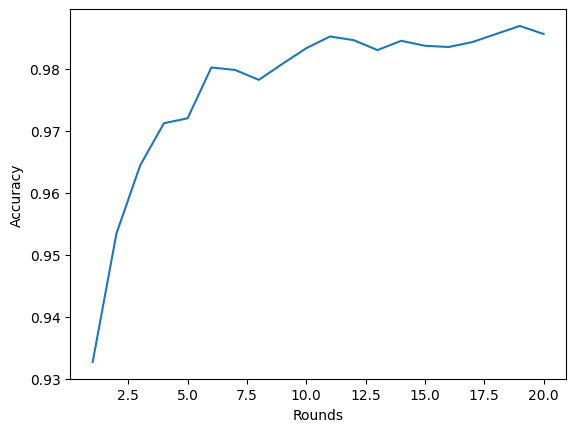

In [25]:
plt.plot(*zip(*history20.metrics_distributed['accuracy']))
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.show()

**Atividade 2** 

Fizemos o aprendizado federado mediado por uma simulação, mas em um cenário real teríamos processos clientes, representando os treinadores, sendo executados em várias máquinas independentes, conectadas a um processo servidor (agregador) pela rede ou pela Internet, por exemplo. 

Como tarefa para casa deve-se  realizar o aprendizado federado de uma maneira mais próxima da realidade, usando processos diferentes para rodar os clientes e o servidor. 

Para isso será necessário criar 2 programas python, o *client.py* e o *server.py*: 


*   O *client.py* deve implementar uma classe que herda a classe  *NumpyClient*, fornecida pela biblioteca flower, instanciar um objeto dessa classe e se conectar ao servidor;
*   O *server.py* deve configurar um servidor de aprendizado federado usando um objeto *strategy* e um objeto *serverConfigserverConfig*. Em seguida deve-se iniciar o servidor para realizar o aprendizado com (no mínimo) 5 clientes.

O *server.py* e o *client.py* devem ser executados em terminais próprios. Isto é, deve se usar um minimo de  6 terminais na solução dessa tarefa: um para o  servidor e um para cada cliente (5 no mínimo). 

Ao final, plotar a acurácia para 2,5, 10, 20 e 40 *rounds* como a quantidade de clientes definida por você (mínimo  5).



Dicas:



*   Não é necessário utilizar várias máquinas para isso;

*    Nesta atividade podemos emular uma rede por meio da interface de rede *localhost* (IP: 127.0.0.1) onde os processos treinadores e servidores podem ser executados em terminais Linux separados conectando-se pelo endereço IP 127.0.0.1;
*   Como referência, usem a [documentação da biblioteca *flower*](https://flower.dev/docs/) na Seção QuickStart tutorials: tensorflow



In [42]:
def read_file(file_name):
    res = []
    file = open(file_name)
    
    for f in file:
        (a,b) = f.split('\n')[0].split(';')
        res.append((int(a),float(b)))

    return res

### 2 Rounds

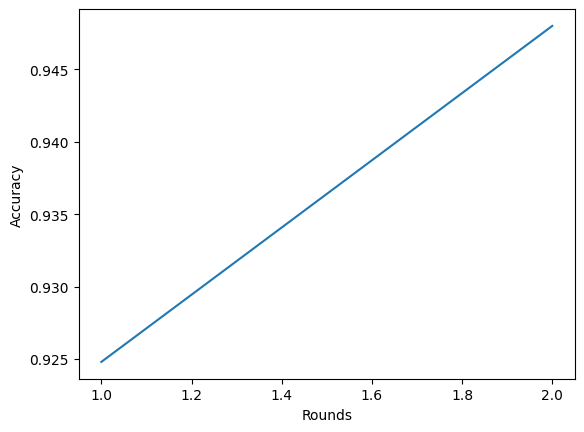

In [53]:
plt.plot(*zip(*read_file('results/result_2.csv')))
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.show()

### 5 Rounds

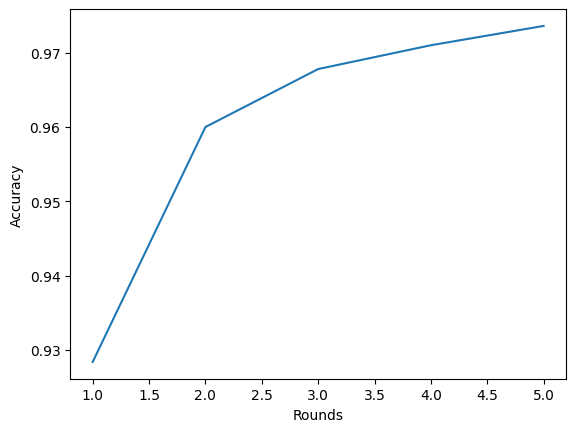

In [54]:
plt.plot(*zip(*read_file('results/result_5.csv')))
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.show()

### 10 Rounds

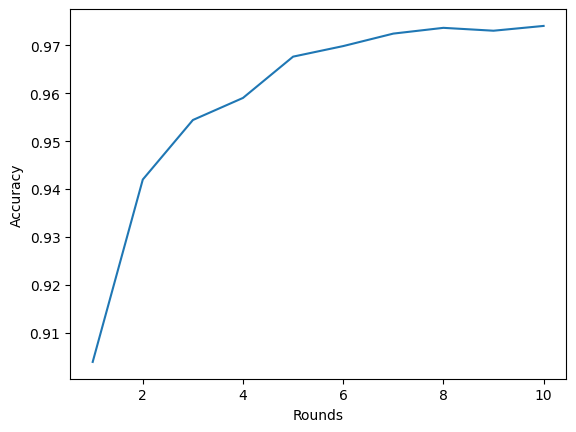

In [55]:
plt.plot(*zip(*read_file('results/result_10.csv')))
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.show()

### 20 Rounds

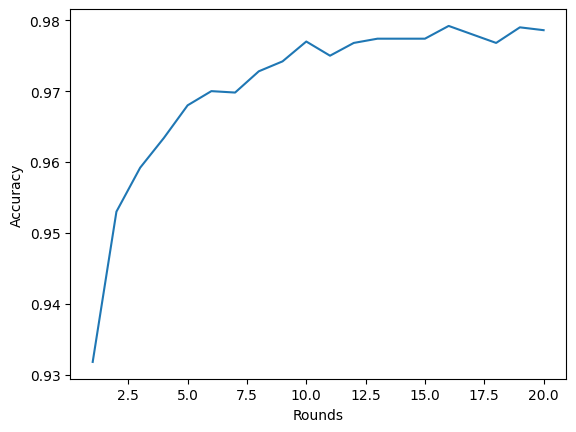

In [56]:
plt.plot(*zip(*read_file('results/result_20.csv')))
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.show()

### 40 Rounds

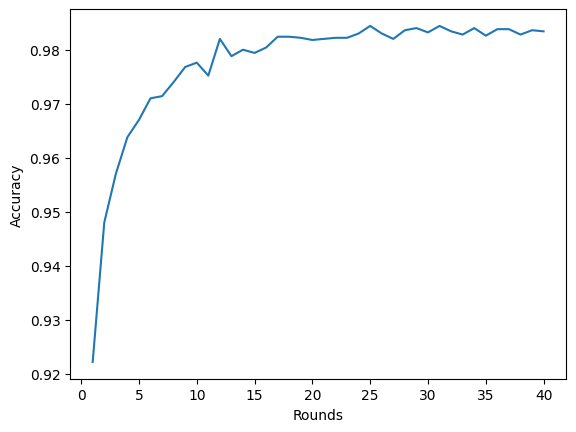

In [58]:
plt.plot(*zip(*read_file('results/result_40.csv')))
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.show()

### Lado a lado

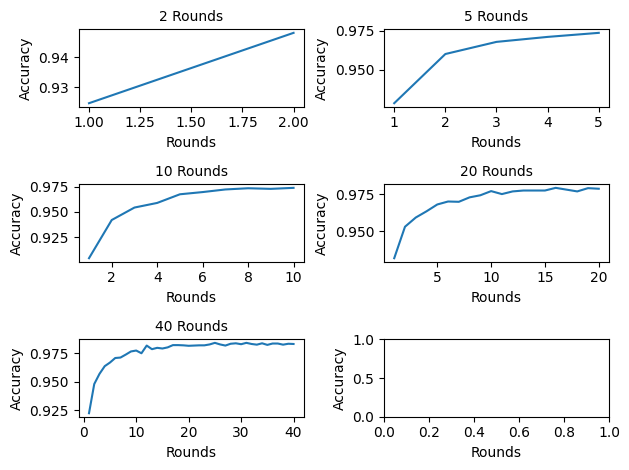

In [86]:
#plt.figure(figsize=(15, 8))

fig, axs = plt.subplots(3, 2)

(x, y) = zip(*read_file('results/result_2.csv'))
axs[0, 0].plot(x, y)
axs[0, 0].set_title('2 Rounds', fontsize=10)

(x, y) = zip(*read_file('results/result_5.csv'))
axs[0, 1].plot(x, y)
axs[0, 1].set_title('5 Rounds', fontsize=10)

(x, y) = zip(*read_file('results/result_10.csv'))
axs[1, 0].plot(x, y)
axs[1, 0].set_title('10 Rounds', fontsize=10)

(x, y) = zip(*read_file('results/result_20.csv'))
axs[1, 1].plot(x, y)
axs[1, 1].set_title('20 Rounds', fontsize=10)

(x, y) = zip(*read_file('results/result_40.csv'))
axs[2, 0].plot(x, y)
axs[2, 0].set_title('40 Rounds', fontsize=10)


[ax.set(xlabel='Rounds', ylabel='Accuracy') for ax in axs.flat]
    
plt.tight_layout();

**Atividade 3**\
**Obrigatória apenas para a pós-graduação** 

Usamos até agora uma rede neural convolucional para gerar o modelo treinado, tanto localmente como de maneira federada, mas o treinamento federado pode ser realizado (teoricamente) com qualquer classe de rede neural. 

Nesta atividade vocês deverão definir pelo menos 2 redes neurais não convolucionais para resolver o problema de classificação de dígitos com o *dataset mnist* e comparar os resultados do treinamento local e federado para essas redes.

Dicas:


*   O treinamento federado pode ser feito tanto por simulação, como este laboratório, ou com os programas *client.py* e *server.py* feitos na atividade anterior.




In [107]:
# Carrega o dataset MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normaliza os pixels das imagens para o intervalo [-0.5, 0.5]
x_train = (x_train / 255.0) - 0.5
x_test = (x_test / 255.0) - 0.5

# Define parametros iniciais
input_shape = (28, 28)
num_classes = 10
epochs = 20

##### Modelo de Rede Neural multilayer perceptron

In [93]:
def define_model(input_shape,num_classes):
    # Cria o modelo da rede neural
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=input_shape),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Compila o modelo
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [94]:
# Cria modelo
model = define_model(shape, num_classes)

In [95]:
# Treina o modelo
model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4531 - accuracy: 0.8598 - val_loss: 0.2128 - val_accuracy: 0.9321
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2509 - accuracy: 0.9239 - val_loss: 0.1461 - val_accuracy: 0.9553
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2028 - accuracy: 0.9388 - val_loss: 0.1339 - val_accuracy: 0.9592
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1817 - accuracy: 0.9454 - val_loss: 0.1240 - val_accuracy: 0.9637
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1656 - accuracy: 0.9495 - val_loss: 0.1317 - val_accuracy: 0.9573
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1564 - accuracy: 0.9523 - val_loss: 0.1008 - val_accuracy: 0.9699
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1465 - accuracy: 0.9549 - val_loss: 0.1161 - val_accuracy:

In [96]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 750us/step - loss: 0.0905 - accuracy: 0.9716


##### Rede Neural simples com duas camadas densas

In [108]:
def define_model():
    # Cria o modelo da rede neural
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=input_shape),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Compila o modelo
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [109]:
#Cria modelo
model = define_model()

In [110]:
# Treina o modelo
model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3462 - accuracy: 0.8971 - val_loss: 0.2176 - val_accuracy: 0.9299
Epoch 2/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1766 - accuracy: 0.9474 - val_loss: 0.1576 - val_accuracy: 0.9526
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1320 - accuracy: 0.9601 - val_loss: 0.1141 - val_accuracy: 0.9639
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1064 - accuracy: 0.9682 - val_loss: 0.1152 - val_accuracy: 0.9645
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0906 - accuracy: 0.9723 - val_loss: 0.1088 - val_accuracy: 0.9652
Epoch 6/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0798 - accuracy: 0.9757 - val_loss: 0.0879 - val_accuracy: 0.9740
Epoch 7/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0722 - accuracy: 0.9772 - val_loss: 0.0924 - val_accuracy:

In [111]:
# Avalia o modelo
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 791us/step - loss: 0.1039 - accuracy: 0.9722


[0.10385064780712128, 0.9721999764442444]